## 0) Setup & Conversione csv -> parquet

In [1]:
import os
from glob import glob
import pyarrow.csv as pacsv
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

print("Librerie importate")

# Impostazioni grafiche uniformi per rendere tutte le figure coerenti e leggibili.

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.0,
    "grid.color": "#CCCCCC",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
})

sns.set_theme(
    style="whitegrid",  
    palette="tab10",    
    font_scale=1.1
)

plt.rcParams["lines.linewidth"] = 2

# Directory dati
DATA_DIR = "data"
PARQUET_DIR = "parquet"
FIGS_DIR = "figs"
OUTPUT_DIR = "output"

# Creazione cartelle 
os.makedirs(PARQUET_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# I dataset originali sono costituiti da molti file CSV di grandi dimensioni.
# Per evitare di saturare la RAM in fase di analisi, ogni CSV viene convertito in formato Parquet, che consente:
#   - lettura colonnare,
#   - compressione più efficiente,
#   - streaming in batch attraverso PyArrow.
# Questo rende il progetto scalabile.

def convert_csv_to_parquet_fast(csv_dir, out_subdir):
    out_dir = os.path.join(PARQUET_DIR, out_subdir)
    os.makedirs(out_dir, exist_ok=True)

    csv_files = sorted(glob(os.path.join(csv_dir, "*.csv")))
    if not csv_files:
        raise ValueError(f"Nessun CSV in {csv_dir}")

    for f in csv_files:
        name = os.path.splitext(os.path.basename(f))[0]
        out_path = os.path.join(out_dir, f"{name}.parquet")

        if os.path.exists(out_path):
            print(f"[SKIP] {name}")
            continue

        print(f"[CSV → PARQUET] {name}")
        table = pacsv.read_csv(f)
        pq.write_table(table, out_path)

    print(f"Conversione completata per {csv_dir}\n")

# Conversione dei tre dataset
convert_csv_to_parquet_fast(os.path.join(DATA_DIR, "invocations"), "invocations")
convert_csv_to_parquet_fast(os.path.join(DATA_DIR, "durations"),   "durations")
convert_csv_to_parquet_fast(os.path.join(DATA_DIR, "memory"),      "memory")

print("Tutti i CSV convertiti in Parquet")

Librerie importate
[SKIP] invocations_per_function_md.anon.d01
[SKIP] invocations_per_function_md.anon.d02
[SKIP] invocations_per_function_md.anon.d03
[SKIP] invocations_per_function_md.anon.d04
[SKIP] invocations_per_function_md.anon.d05
[SKIP] invocations_per_function_md.anon.d06
[SKIP] invocations_per_function_md.anon.d07
[SKIP] invocations_per_function_md.anon.d08
[SKIP] invocations_per_function_md.anon.d09
[SKIP] invocations_per_function_md.anon.d10
[SKIP] invocations_per_function_md.anon.d11
[SKIP] invocations_per_function_md.anon.d12
[SKIP] invocations_per_function_md.anon.d13
[SKIP] invocations_per_function_md.anon.d14
Conversione completata per data\invocations

[SKIP] function_durations_percentiles.anon.d01
[SKIP] function_durations_percentiles.anon.d02
[SKIP] function_durations_percentiles.anon.d03
[SKIP] function_durations_percentiles.anon.d04
[SKIP] function_durations_percentiles.anon.d05
[SKIP] function_durations_percentiles.anon.d06
[SKIP] function_durations_percentiles.

## 1) Caricamento parquet

In [2]:
# Creazione di tre dataset Arrow distinti. Arrow non carica i file in memoria ma opera in streaming. 
# Ogni dataset corrisponde a una parte del workload:
#   - invocations: volumi temporali minuto per minuto,
#   - durations: tempi di esecuzione delle funzioni,
#   - memory: profili di memoria allocata dalle app.

INV_PATH = os.path.join(PARQUET_DIR, "invocations")
DUR_PATH = os.path.join(PARQUET_DIR, "durations")
MEM_PATH = os.path.join(PARQUET_DIR, "memory")

ds_invocations = ds.dataset(INV_PATH, format="parquet")
ds_durations   = ds.dataset(DUR_PATH, format="parquet")
ds_memory      = ds.dataset(MEM_PATH, format="parquet")

print("Dataset Arrow pronti")

Dataset Arrow pronti


## 2) Esplorazione dei Dataset

In [3]:
# Funzione di ispezione: permette di verificare la struttura dei dataset
# senza caricarli integralmente.
# Utile per effettuare controlli preliminari sulla correttezza dei file caricati.

def quick_info(dataset, name, sample_rows=5):
    print(f"\n=== {name.upper()} ===")

    # Numero record
    n_rows = dataset.count_rows()
    print(f"Record: {n_rows:,}")

    # Prime 10 colonne
    schema_cols = [f"{f.name}:{f.type}" for f in dataset.schema][:10]
    print(f"Colonne (prime 10 su {len(dataset.schema)} totali):")
    for c in schema_cols:
        print(" -", c)

    # Campione
    sample_table = dataset.head(sample_rows)
    df_sample = sample_table.to_pandas()
    
    print("\nPrime righe campione:")
    display(df_sample)

print("Esplorazione veloce con Arrow + batch streaming")

quick_info(ds_invocations, "Invocations")
quick_info(ds_durations,   "Durations")
quick_info(ds_memory,      "Memory")

Esplorazione veloce con Arrow + batch streaming

=== INVOCATIONS ===
Record: 618,545
Colonne (prime 10 su 1444 totali):
 - HashOwner:string
 - HashApp:string
 - HashFunction:string
 - Trigger:string
 - 1:int64
 - 2:int64
 - 3:int64
 - 4:int64
 - 5:int64
 - 6:int64

Prime righe campione:


,HashOwner,HashApp,HashFunction,Trigger,1,2,3,4,5,6,...,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440
0,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...,520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...,http,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...,115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...,http,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed8...,orchestration,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,740c5c767e4b9978ee59a97d1829cfbaf755a47806a311...,http,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...,c108b4864b866b38b80d0e4594cc6d038f39668b804a1b...,http,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



=== DURATIONS ===
Record: 662,927
Colonne (prime 10 su 14 totali):
 - HashOwner:string
 - HashApp:string
 - HashFunction:string
 - Average:int64
 - Count:int64
 - Minimum:double
 - Maximum:double
 - percentile_Average_0:int64
 - percentile_Average_1:int64
 - percentile_Average_25:int64

Prime righe campione:


,HashOwner,HashApp,HashFunction,Average,Count,Minimum,Maximum,percentile_Average_0,percentile_Average_1,percentile_Average_25,percentile_Average_50,percentile_Average_75,percentile_Average_99,percentile_Average_100
0,5640c1597ef75fa9a7e9c6925022a039a4ba9829241709...,5126901eff078c9a1f5295c859c9327588284a43cc2c0b...,c968871b4ef0123401975d026b85cae2ad7dad9d06ae94...,100,2880,0.0,2595.0,0,0,0,1,1,1376,2595
1,5640c1597ef75fa9a7e9c6925022a039a4ba9829241709...,5126901eff078c9a1f5295c859c9327588284a43cc2c0b...,1bc2d86badd21b18a8533d8e961e52585e5ad1fee0e2c2...,202,365,0.0,2596.0,0,0,1,1,6,2326,2596
2,41d6e09d0f86f5aaa1df842c1ac4f14fbd4dc676bec7e0...,77a93348150f5281c32c9027870a77983ad6eba72e6c28...,b4d7cb9985cd8c1b7fe5ef888bbde1883929e9a5b5d2a6...,11,37815,1.0,3913.0,1,1,3,5,8,155,3146
3,e117b8c1676e11d859824b18fc0202ae8eaa89cb3f58e2...,5c84cc1fbc4261f22d6f626304670979c1f1b94709acc8...,ff612aae7b380ef81ccef063ff814354ee16018af65dc1...,0,34466,0.0,123.0,0,0,0,0,0,1,10
4,3c8c13c6bd162490dae4402bcb9ff1e5c6c14bb21da35a...,3b80dfff065220947f7d626dd6c9176731d3e17591e496...,ee79840da82525548358f4b91d9fa1e550ec7af36bbe3e...,389,288,78.0,5607.0,78,78,109,136,180,4761,5607



=== MEMORY ===
Record: 206,809
Colonne (prime 10 su 12 totali):
 - HashOwner:string
 - HashApp:string
 - SampleCount:int64
 - AverageAllocatedMb:int64
 - AverageAllocatedMb_pct1:int64
 - AverageAllocatedMb_pct5:int64
 - AverageAllocatedMb_pct25:int64
 - AverageAllocatedMb_pct50:int64
 - AverageAllocatedMb_pct75:int64
 - AverageAllocatedMb_pct95:int64

Prime righe campione:


,HashOwner,HashApp,SampleCount,AverageAllocatedMb,AverageAllocatedMb_pct1,AverageAllocatedMb_pct5,AverageAllocatedMb_pct25,AverageAllocatedMb_pct50,AverageAllocatedMb_pct75,AverageAllocatedMb_pct95,AverageAllocatedMb_pct99,AverageAllocatedMb_pct100
0,71ca12c7af70d021e285b51b245942f8432df6463ff9f2...,7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...,17235,108,108,108,108,109,109,109,110,110
1,dca6b75d51b494146b50f93b0f1a863ce99164942695e8...,cfccc67d83c3c4dc1dd075e77e41232282e4d7a75d2ba9...,536284,322,167,199,251,307,357,532,692,991
2,e564f454ffe6e39c133b43183ca5c1537fec3a55b3a73c...,93db1e4c30e99d1c416ee453dd67504641b88144e23219...,34726,673,175,301,471,679,875,1036,1179,1288
3,15d422b003e198041546b5a1b46aa4d3aaada57de592a8...,e59cebb1c16975c6ee9dd52430c55380dc305ae1fb9171...,17238,95,95,95,96,96,96,96,96,96
4,f5b5e5b8537dd76458e850d7c0dc4057dcd8e0dfa50d36...,fb68374027828434785f3c5ce09fcdc2e44212559643bd...,19927,204,182,185,202,206,211,214,223,292


## 3) Panorama generale


Cardinalità:
- Owner totali:    14,681
- App totali:      24,274
- Funzioni totali: 72,359

Copertura dataset:
- Funzioni con durations:  71,597
- Funzioni senza durations: 762
- App con memory:          23,431
- App senza memory:        843



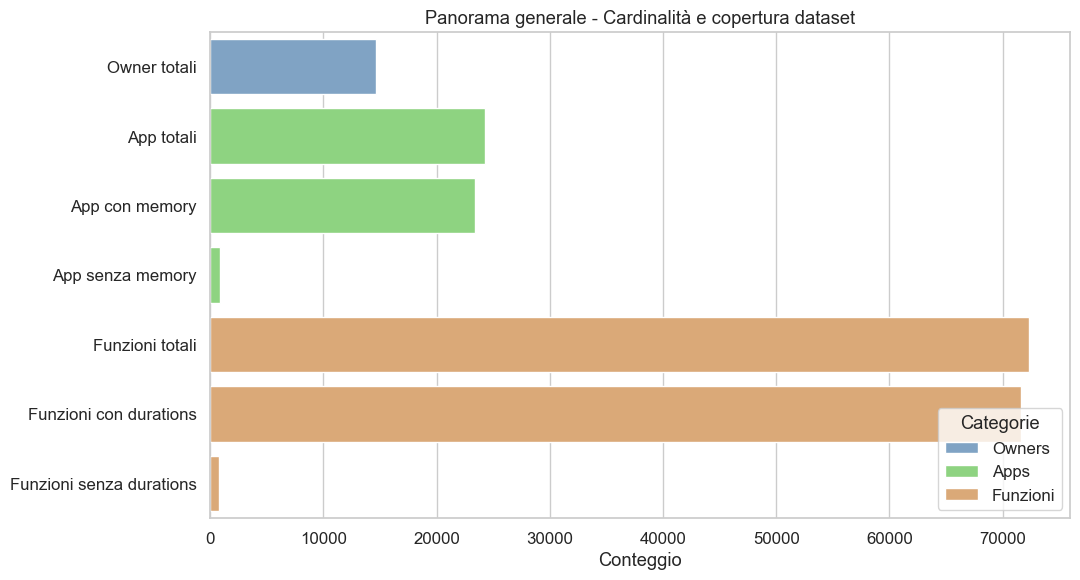

In [4]:
# Estrae solamente le colonne chiave dei tre dataset (Owner, App, Function)
# per valutare dimensione, copertura e sovrapposizione tra le tre fonti dati.

inv_keys = ds_invocations.to_table(columns=["HashOwner", "HashApp", "HashFunction"])
dur_keys = ds_durations.to_table(columns=["HashOwner", "HashApp", "HashFunction"])
mem_keys = ds_memory.to_table(columns=["HashOwner", "HashApp"])

inv_df = inv_keys.to_pandas()
dur_df = dur_keys.to_pandas()
mem_df = mem_keys.to_pandas()

n_owners = inv_df['HashOwner'].nunique()
n_apps   = inv_df['HashApp'].nunique()
n_funcs  = inv_df['HashFunction'].nunique()

print("Cardinalità:")
print(f"- Owner totali:    {n_owners:,}")
print(f"- App totali:      {n_apps:,}")
print(f"- Funzioni totali: {n_funcs:,}\n")

# Verifica quali funzioni hanno il corrispondente record di durata,
# e quali applicazioni presentano dati relativi alla memoria allocata.
# Nota: i tre dataset non sono completamente allineati.

fun_with_dur = set(inv_df["HashFunction"]) & set(dur_df["HashFunction"])
n_fun_dur   = len(fun_with_dur)
n_fun_no_dur = n_funcs - n_fun_dur

app_with_mem = set(inv_df["HashApp"]) & set(mem_df["HashApp"])
n_app_mem   = len(app_with_mem)
n_app_no_mem = n_apps - n_app_mem

print("Copertura dataset:")
print(f"- Funzioni con durations:  {n_fun_dur:,}")
print(f"- Funzioni senza durations: {n_fun_no_dur:,}")
print(f"- App con memory:          {n_app_mem:,}")
print(f"- App senza memory:        {n_app_no_mem:,}\n")

# Creazione CSV riepilogativo

summary_df = pd.DataFrame({
    "Metric": [
        "Owner totali", "App totali", "App con memory", "App senza memory",
        "Funzioni totali", "Funzioni con durations", "Funzioni senza durations"
    ],
    "Value": [
        n_owners, n_apps, n_app_mem, n_app_no_mem,
        n_funcs, n_fun_dur, n_fun_no_dur
    ]
})

summary_df.to_csv(os.path.join(OUTPUT_DIR, "panorama_generale_summary.csv"),
                  index=False, sep=';', encoding='utf-8')

# Costruzione di un riepilogo compatto delle principali dimensioni del dataset.

ordered_metrics = [
    "Owner totali",
    "App totali", "App con memory", "App senza memory",
    "Funzioni totali", "Funzioni con durations", "Funzioni senza durations"
]

summary_df["Metric"] = pd.Categorical(summary_df["Metric"],
                                      categories=ordered_metrics,
                                      ordered=True)
summary_df = summary_df.sort_values("Metric")

category_map = {
    "Owner totali": "Owners",
    "App totali": "Apps",
    "App con memory": "Apps",
    "App senza memory": "Apps",
    "Funzioni totali": "Funzioni",
    "Funzioni con durations": "Funzioni",
    "Funzioni senza durations": "Funzioni"
}

summary_df["Categoria"] = summary_df["Metric"].map(category_map)

category_palette = {
    "Owners":   "#75a4cf",  
    "Apps":     "#85e173", 
    "Funzioni": "#eaa968",  
}

plt.figure(figsize=(11, 6))
ax = sns.barplot(
    x="Value",
    y="Metric",
    data=summary_df,
    hue="Categoria",      
    dodge=False,
    palette=category_palette
)

plt.title("Panorama generale - Cardinalità e copertura dataset")
plt.xlabel("Conteggio")
plt.ylabel("")
plt.legend(title="Categorie", loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "panorama_generale_summary.png"))
plt.show()


## 4) Analisi delle Invocazioni

Analisi invocazioni in streaming per RAM limitata...


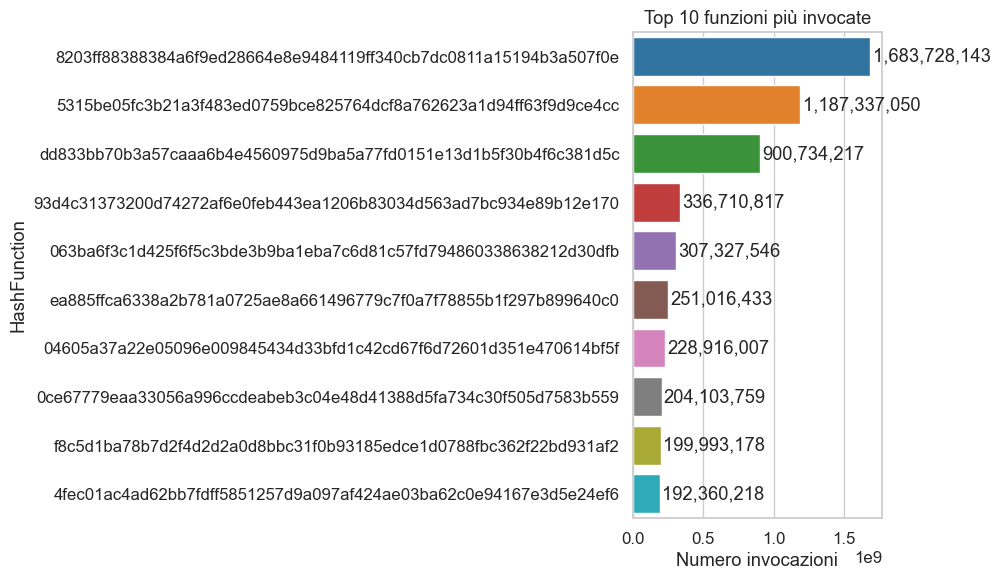


Top 3 funzioni più invocate:
1. 8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e - 1,683,728,143 invocazioni
2. 5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc - 1,187,337,050 invocazioni
3. dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c - 900,734,217 invocazioni


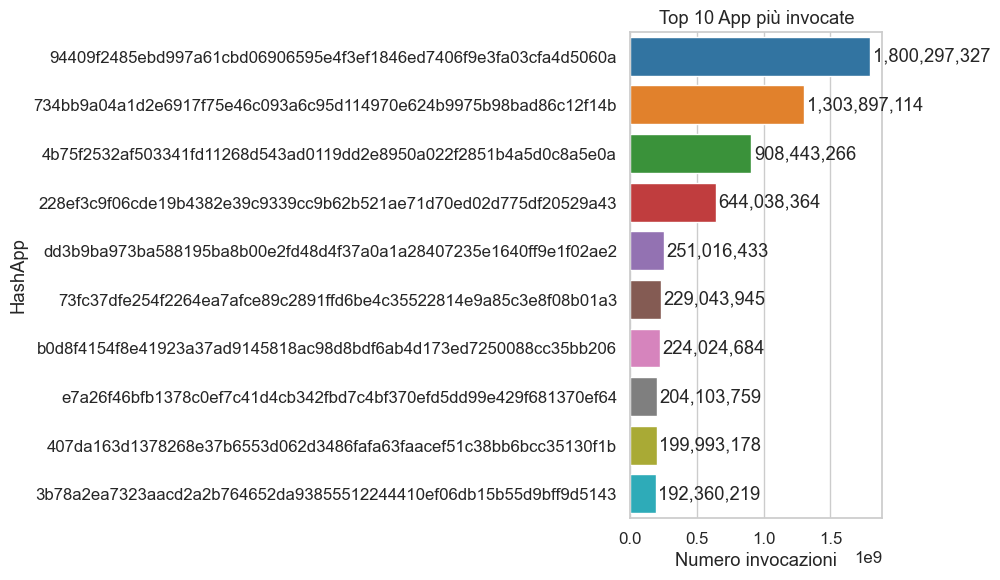


Top 3 app più invocate:
1. 94409f2485ebd997a61cbd06906595e4f3ef1846ed7406f9e3fa03cfa4d5060a - 1,800,297,327 invocazioni
2. 734bb9a04a1d2e6917f75e46c093a6c95d114970e624b9975b98bad86c12f14b - 1,303,897,114 invocazioni
3. 4b75f2532af503341fd11268d543ad0119dd2e8950a022f2851b4a5d0c8a5e0a - 908,443,266 invocazioni


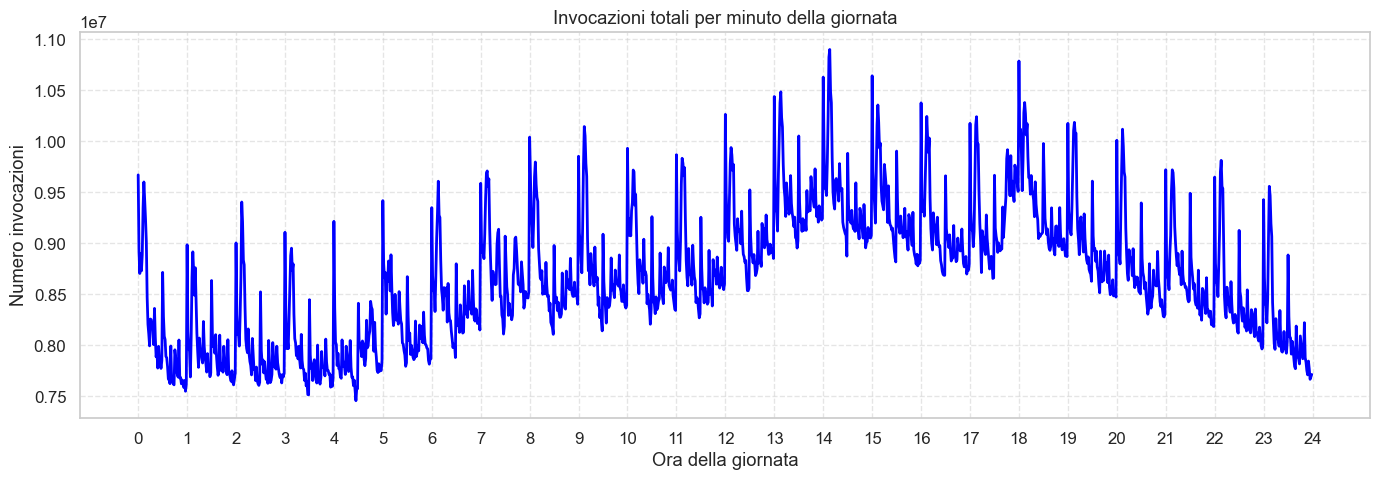

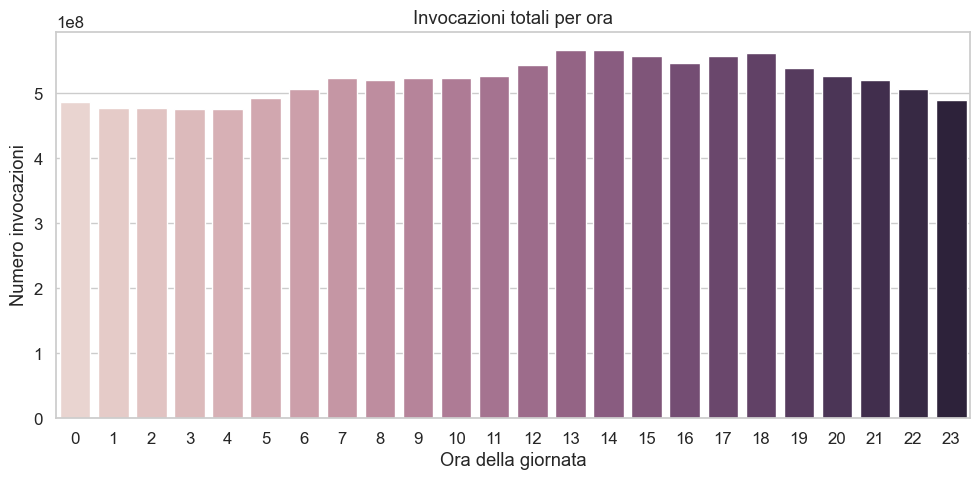

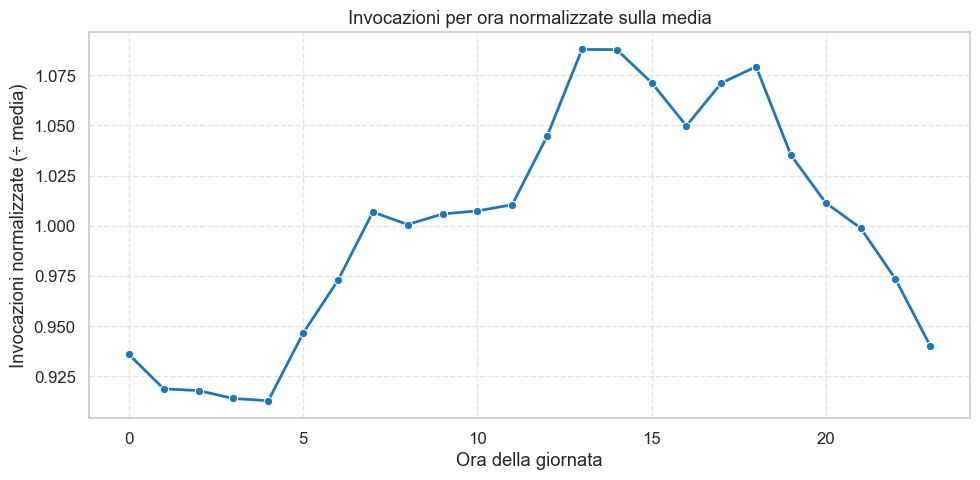


Minuto di picco: 848 (14:8)
Minuto minimo: 267 (4:27)
Analisi delle invocazioni completata. Figure e CSV salvati in 'figs/' e 'output/'


In [5]:
print("Analisi invocazioni in streaming per RAM limitata...")

# Ogni file delle invocazioni contiene 1440 colonne numeriche, una per ogni minuto della giornata. 
# Per ciascun batch viene calcolato il numero totale di invocazioni
# per funzione e per applicazione sommando le 1440 colonne.
# L'elaborazione è interamente in streaming per evitare l'allocazione di tabelle enormi.

time_cols = [str(i) for i in range(1, 1441)]
key_cols = ["HashOwner", "HashApp", "HashFunction"]
all_cols = key_cols + time_cols

func_counter = Counter()
app_counter  = Counter()
time_series_total = np.zeros(1440, dtype=np.int64)

# Analisi in streaming: ogni batch contiene solo una frazione dei dati,
# permettendo di elaborare l’intero dataset senza mai caricare tutto in RAM.

for batch in ds_invocations.to_batches(columns=all_cols):
    batch_df = batch.to_pandas()
    
    # Totale invocazioni per funzione
    func_counter.update(batch_df.groupby("HashFunction")[time_cols].sum().sum(axis=1).to_dict())
    
    # Totale invocazioni per app
    app_counter.update(batch_df.groupby("HashApp")[time_cols].sum().sum(axis=1).to_dict())
    
    # Serie temporale totale
    time_series_total += batch_df[time_cols].sum(axis=0).to_numpy()


# Top 10 funzioni più invocate
func_counts = pd.Series(func_counter).sort_values(ascending=False)
top10_funcs = pd.DataFrame({"Function": func_counts.index[:10], "Count": func_counts.values[:10]})
top10_funcs.to_csv(os.path.join(OUTPUT_DIR, "top10_functions.csv"), index=False, sep=';', encoding='utf-8')

plt.figure(figsize=(10,6))
ax = sns.barplot(x="Count", y="Function", data=top10_funcs, hue="Function", dodge=False, legend=False)
plt.title("Top 10 funzioni più invocate")
plt.xlabel("Numero invocazioni")
plt.ylabel("HashFunction")
plt.legend([], [], frameon=False)

for i, row in top10_funcs.iterrows():
    ax.text(row['Count'] + top10_funcs['Count'].max()*0.01, i, f"{row['Count']:,}", va='center')

plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "top10_functions.png"))
plt.show()

# Top 3 funzioni più invocate
print("\nTop 3 funzioni più invocate:")
for i, row in top10_funcs.head(3).iterrows():
    print(f"{i+1}. {row['Function']} - {row['Count']:,} invocazioni")

# Top 10 app più invocate
app_counts = pd.Series(app_counter).sort_values(ascending=False)
top10_apps = pd.DataFrame({"App": app_counts.index[:10], "Count": app_counts.values[:10]})
top10_apps.to_csv(os.path.join(OUTPUT_DIR, "top10_apps.csv"), index=False, sep=';', encoding='utf-8')

plt.figure(figsize=(10,6))
ax = sns.barplot(x="Count", y="App", data=top10_apps, hue="App", dodge=False, legend=False)
plt.title("Top 10 App più invocate")
plt.xlabel("Numero invocazioni")
plt.ylabel("HashApp")
plt.legend([], [], frameon=False)

for i, row in top10_apps.iterrows():
    ax.text(row['Count'] + top10_apps['Count'].max()*0.01, i, f"{row['Count']:,}", va='center')

plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "top10_apps.png"))
plt.show()

# Top 3 app più invocate
print("\nTop 3 app più invocate:")
for i, row in top10_apps.head(3).iterrows():
    print(f"{i+1}. {row['App']} - {row['Count']:,} invocazioni")

# Aggregazione dei valori dei 1440 minuti su tutte le funzioni per produrre
# la serie temporale delle invocazioni nell’arco della giornata.
minutes = np.arange(1440)
hours = minutes / 60

plt.figure(figsize=(14,5))
plt.plot(hours, time_series_total, label="Invocazioni per minuto", color="blue")
plt.title("Invocazioni totali per minuto della giornata")
plt.xlabel("Ora della giornata")
plt.ylabel("Numero invocazioni")
plt.xticks(np.arange(0,25,1))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "total_time_series.png"))
plt.show()

# Invocazioni aggregate per ora
hourly_series = time_series_total.reshape(24, 60).sum(axis=1)
hourly_df = pd.DataFrame({"Hour": np.arange(24), "Count": hourly_series})
hourly_df.to_csv(os.path.join(OUTPUT_DIR, "hourly_total.csv"), index=False, sep=';', encoding='utf-8')

plt.figure(figsize=(10,5))
sns.barplot(x="Hour", y="Count", data=hourly_df, hue="Hour", dodge=False, legend=False)
plt.title("Invocazioni totali per ora")
plt.xlabel("Ora della giornata")
plt.ylabel("Numero invocazioni")
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "hourly_total.png"))
plt.show()

# Serie oraria normalizzata sulla media
hourly_norm = hourly_series / hourly_series.mean()

norm_df = pd.DataFrame({
    "Hour": np.arange(24),
    "Normalized": hourly_norm
})

plt.figure(figsize=(10,5))
sns.lineplot(x="Hour", y="Normalized", data=norm_df, marker="o")
plt.title("Invocazioni per ora normalizzate sulla media")
plt.xlabel("Ora della giornata")
plt.ylabel("Invocazioni normalizzate (÷ media)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "hourly_normalized.png"))
plt.show()

# Picco/minimo
peak_minute = np.argmax(time_series_total)
min_minute = np.argmin(time_series_total)
print(f"\nMinuto di picco: {peak_minute} ({peak_minute//60}:{peak_minute%60})")
print(f"Minuto minimo: {min_minute} ({min_minute//60}:{min_minute%60})")

print("Analisi delle invocazioni completata. Figure e CSV salvati in 'figs/' e 'output/'")

## 4b) Analisi dei trigger

Analisi approfondita dei trigger...


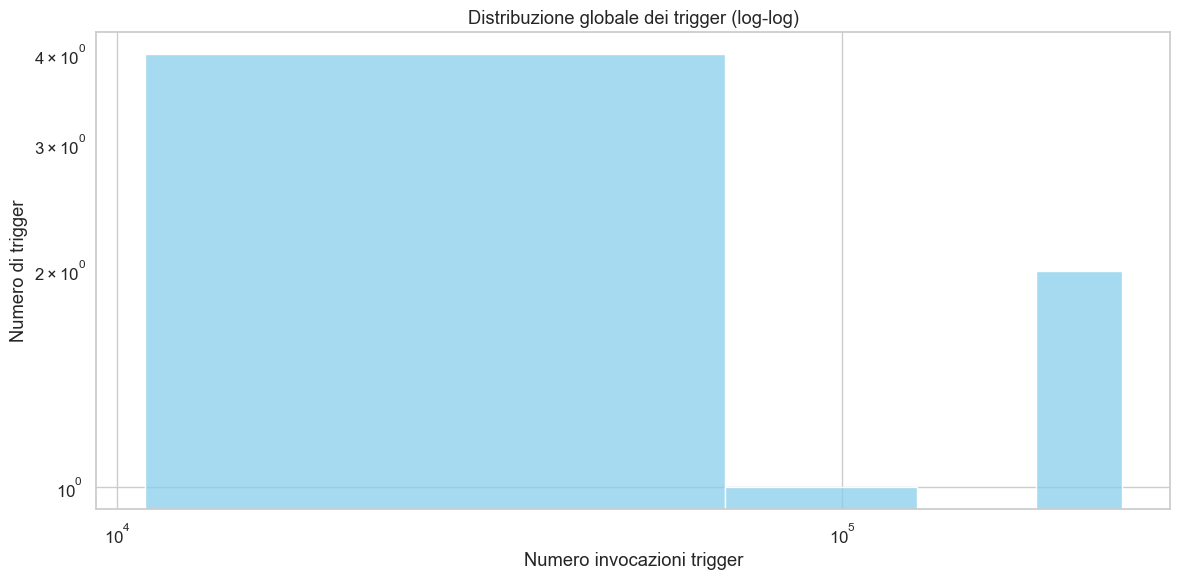

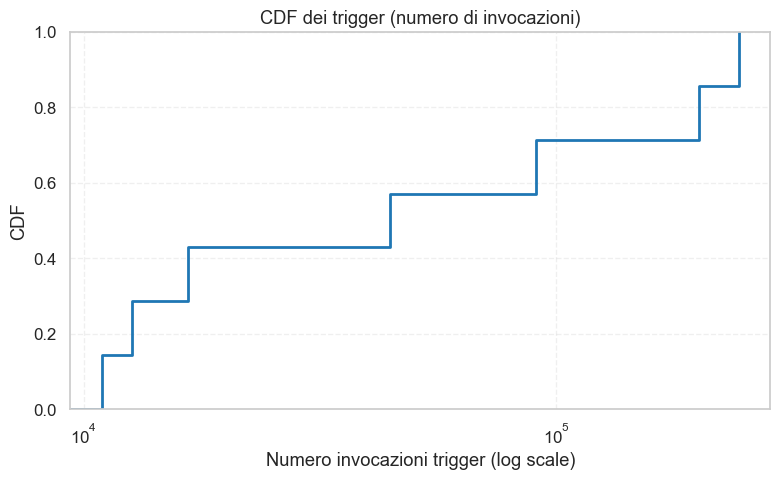

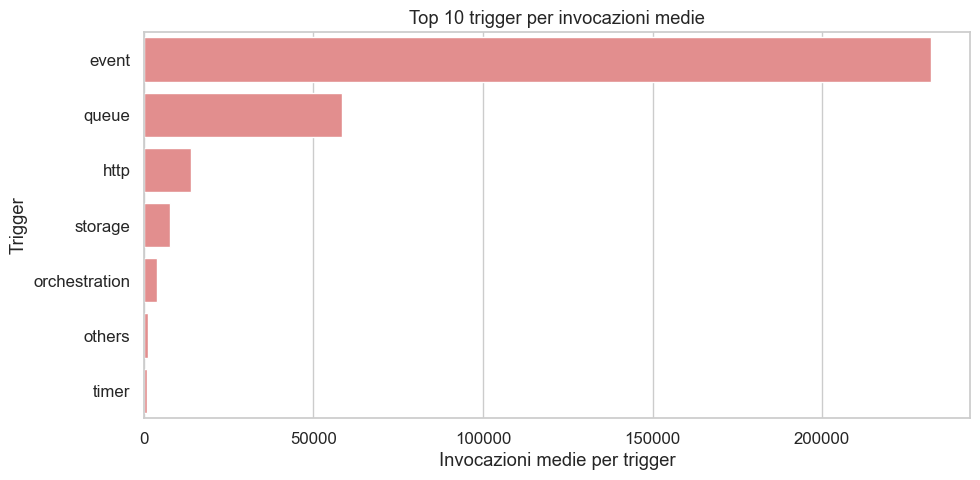


Top 10 trigger per invocazioni medie:
event            232123.308870
queue             58519.123058
http              14041.875911
storage            7715.288161
orchestration      3943.283101
others             1393.957792
timer               937.802945
dtype: float64
\Distribuzione trigger per numero di funzioni
Trigger
http             30440
timer            20074
queue            10601
orchestration     5761
others            3998
event             1859
storage           1614
Name: HashFunction, dtype: int64


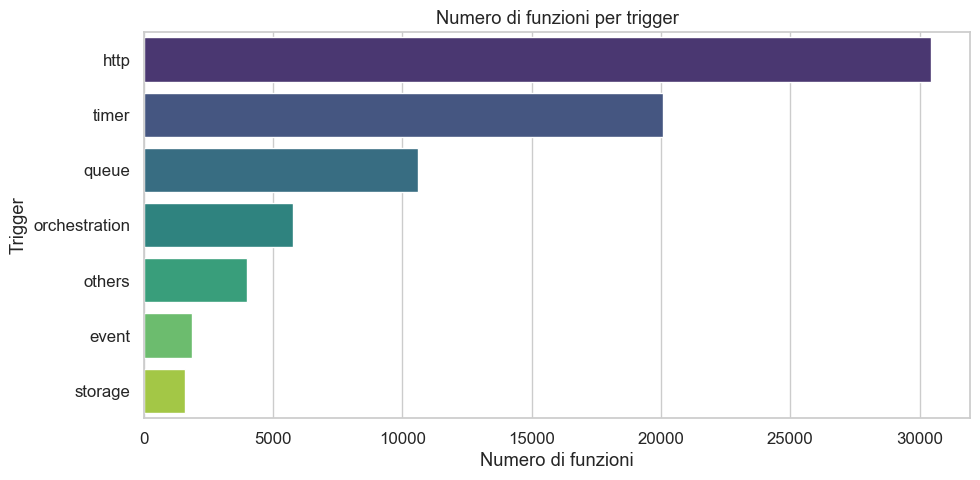

Analisi dei trigger completata. Figure e CSV salvati in 'figs/' e 'output/'


In [6]:
print("Analisi approfondita dei trigger...")

# I trigger rappresentano la causa che attiva una funzione (HTTP, Timer,...).
# Per ciascun trigger si calcola:
#   - il numero totale di attivazioni,
#   - la distribuzione delle invocazioni medie,
#   - il numero di funzioni che utilizzano quel trigger.
# L’analisi permette di identificare quali trigger dominano il workload
# e di caratterizzare il comportamento dell’intero sistema.

# Inizializzazione contatori
trigger_counter = Counter()           
trigger_durations = defaultdict(list) 

minute_cols = [str(i) for i in range(1, 1441)]  # Colonne temporali

# Streaming batch
for batch in ds_invocations.to_batches(columns=["Trigger"] + minute_cols):
    df = batch.to_pandas()
    
    # Totale invocazioni per riga
    df["TotalInvocations"] = df[minute_cols].sum(axis=1)
    
    # Conteggio totale trigger
    trigger_counter.update(df["Trigger"].to_list())
    
    # Accumulo invocazioni per media
    for trig, group in df.groupby("Trigger"):
        trigger_durations[trig].extend(group["TotalInvocations"].tolist())

# Serie globale dei trigger
all_triggers_counts = pd.Series(trigger_counter).sort_values(ascending=False)

# Salvataggio CSV 
all_triggers_df = pd.DataFrame({
    "Trigger": all_triggers_counts.index,
    "Count": all_triggers_counts.values
})
all_triggers_df.to_csv(os.path.join(OUTPUT_DIR, "all_triggers.csv"), index=False, sep=';', encoding='utf-8')

# Distribuzione dei trigger
plt.figure(figsize=(12,6))
sns.histplot(all_triggers_counts.values, bins='auto', color="skyblue")
plt.yscale("log")
plt.xscale("log")
plt.title("Distribuzione globale dei trigger (log-log)")
plt.xlabel("Numero invocazioni trigger")
plt.ylabel("Numero di trigger")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "triggers_distribution_loglog.png"))
plt.show()

# CDF dei trigger
plt.figure(figsize=(8,5))
sns.ecdfplot(all_triggers_counts.values)
plt.xscale("log")
plt.title("CDF dei trigger (numero di invocazioni)")
plt.xlabel("Numero invocazioni trigger (log scale)")
plt.ylabel("CDF")
plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "triggers_cdf.png"))
plt.show()

# Top 10 trigger per invocazioni medie
trigger_avg = {k: np.mean(v) for k,v in trigger_durations.items() if len(v) > 0}
top10_trigger_avg = pd.Series(trigger_avg).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top10_trigger_avg.values, y=top10_trigger_avg.index, dodge=False, color="lightcoral")
plt.title("Top 10 trigger per invocazioni medie")
plt.xlabel("Invocazioni medie per trigger")
plt.ylabel("Trigger")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "top10_trigger_avg.png"))
plt.show()

print("\nTop 10 trigger per invocazioni medie:")
print(top10_trigger_avg)

# Distribuzione trigger per funzioni
print("\Distribuzione trigger per numero di funzioni")

trigger_func_df = ds_invocations.to_table(columns=["HashFunction", "Trigger"]) \
                                .to_pandas() \
                                .drop_duplicates()

trigger_func_count = trigger_func_df.groupby("Trigger")["HashFunction"].count() \
                                    .sort_values(ascending=False)

print(trigger_func_count)

# Salvataggio CSV
trigger_func_count.to_csv(
    os.path.join(OUTPUT_DIR, "trigger_per_function.csv"),
    sep=';', encoding='utf-8'
)

plt.figure(figsize=(10,5))
sns.barplot(
    x="Count",
    y="Trigger",
    data=trigger_func_count.reset_index().rename(columns={"HashFunction": "Count"}),
    hue="Trigger",
    dodge=False,
    legend=False,
    palette="viridis"
)

plt.title("Numero di funzioni per trigger")
plt.xlabel("Numero di funzioni")
plt.ylabel("Trigger")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "trigger_per_function.png"))
plt.show()

print("Analisi dei trigger completata. Figure e CSV salvati in 'figs/' e 'output/'")

## 5) Analisi delle Durate

Analisi delle durate in streaming per RAM limitata... 
Statistiche globali delle durate (ms):
- Median: 672.00
- P90: 16803.00
- P95: 42644.90
- P99: 224665.13
- Mean: 10039.36
- Min: 0.00
- Max: 1800409.00
\Generazione CDF per Average, Minimum e Maximum


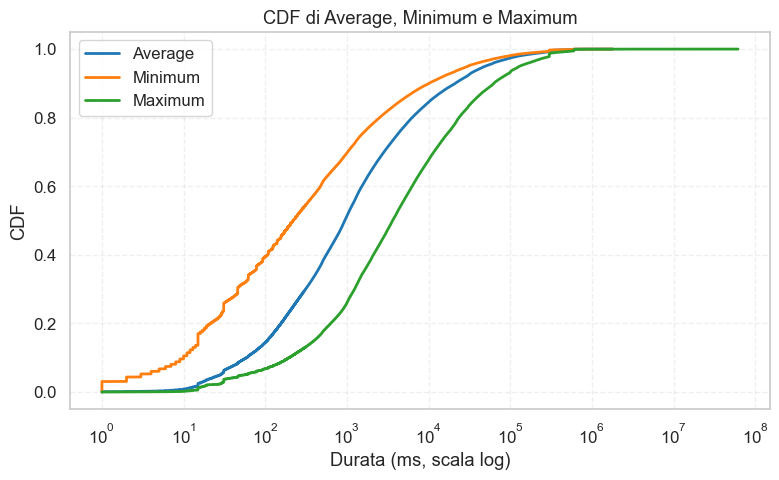

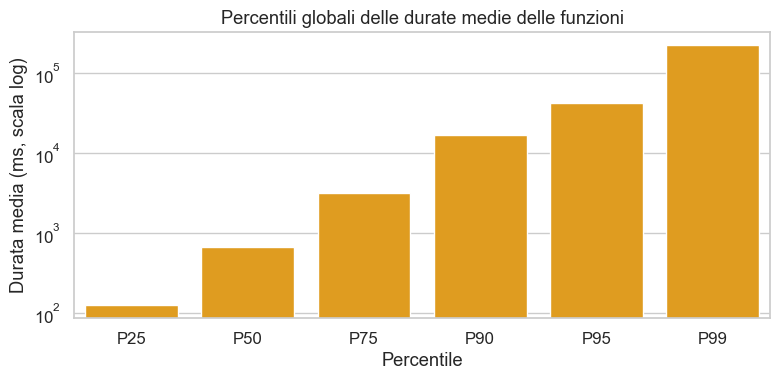

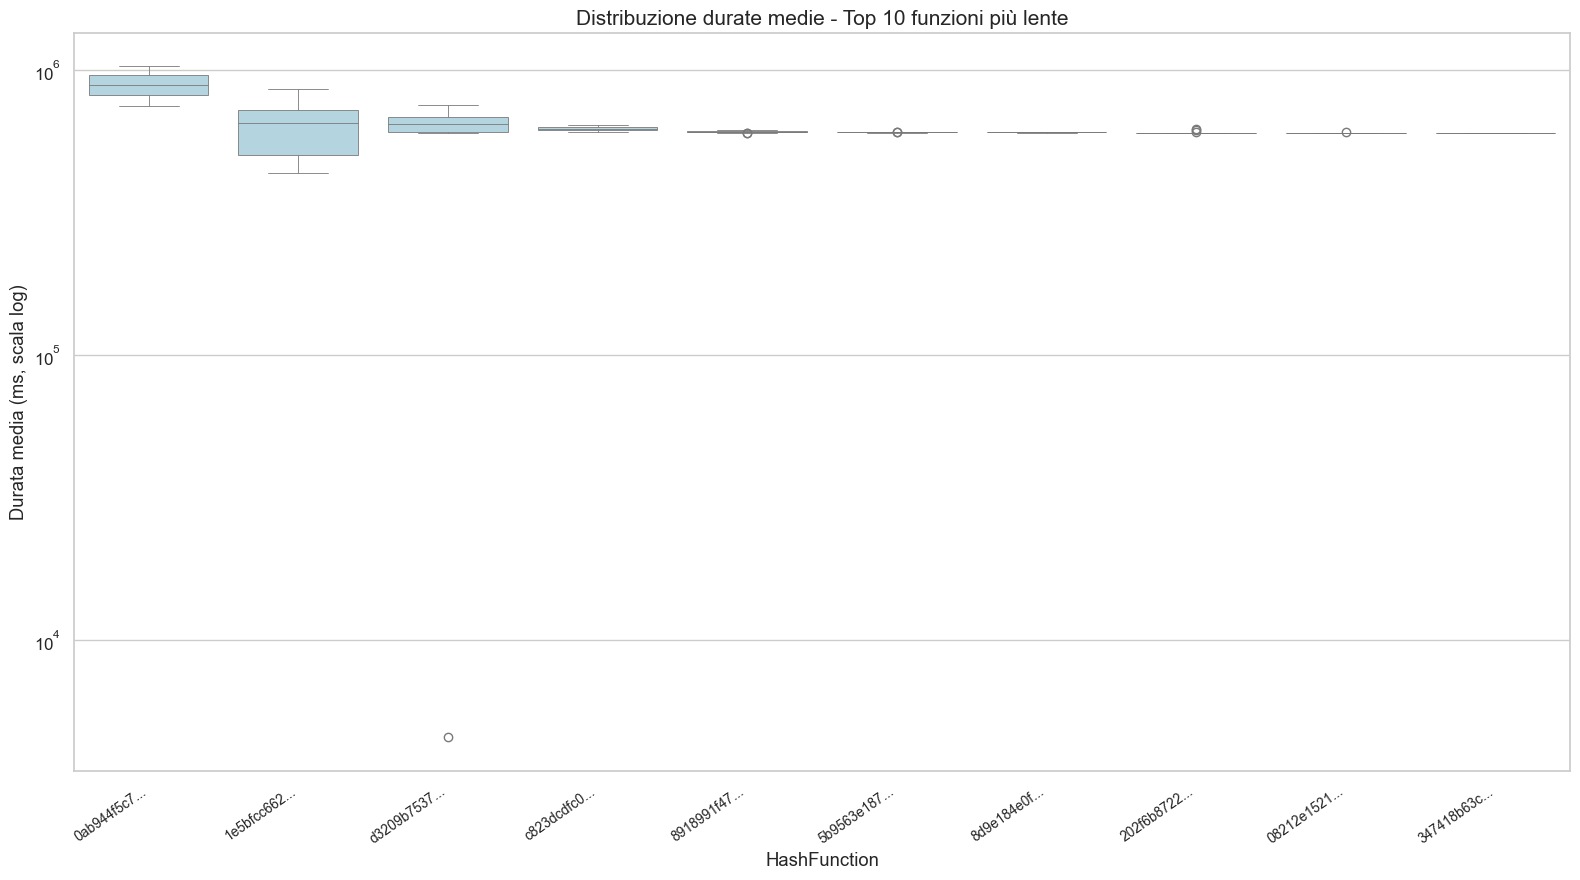


Top 3 funzioni più lente (mediana):
1. 0ab944f5c72a4b9f807931d23f704cfaf8296477f3c4a64fe77807280fcd5c6c - 886277.00 ms
2. 1e5bfcc662ff982b62ca347d1058f43780275234da00b4b5162e6a887d82a56a - 650456.00 ms
3. d3209b753752c8641cde05ba81b3ceb0d175b1f986fee7872a9368cd16d18120 - 644505.00 ms


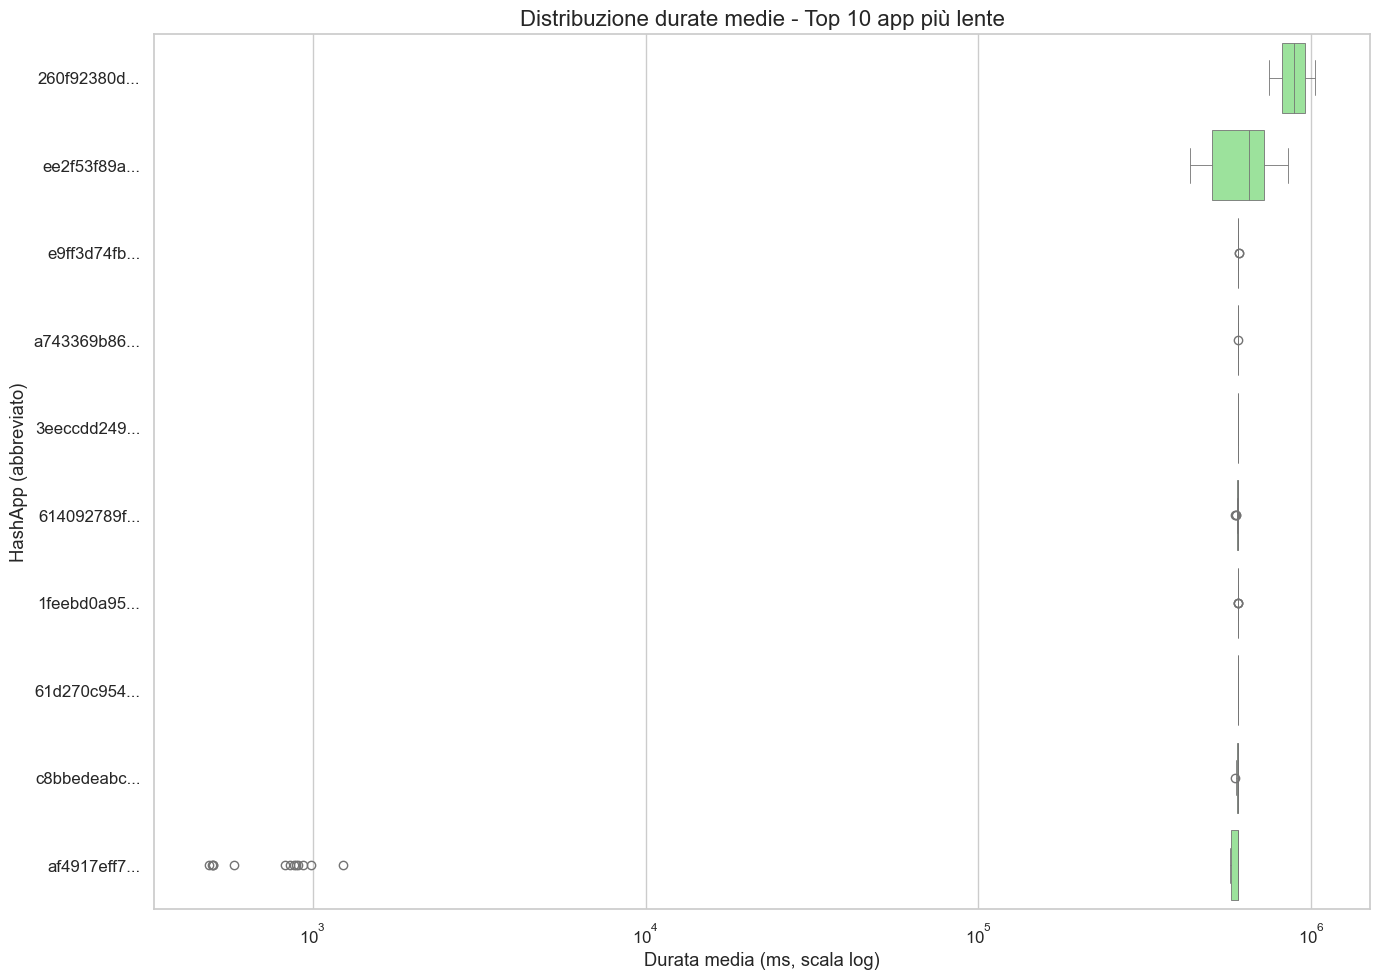

Top 3 app più lente (mediana):
1. 260f92380d3593ad674a83c99de3cd37d0478ed2bc1e6d08b7e2bed55a4080eb - 886277.00 ms
2. ee2f53f89a35c322a948262c5b545eb46df8ca96d47754b900765d1a46d9a285 - 650456.00 ms
3. e9ff3d74fbb5d65360c2e37216460990c39cd06bc4a409d2ab6f5c0e588c026a - 602960.00 ms
Analisi delle durate completata. Figure e CSV salvati in 'figs/' e 'output/'


In [7]:
print("Analisi delle durate in streaming per RAM limitata... ")

# Contatori e raccolta durate per funzione/app
func_durations = defaultdict(list)
app_durations  = defaultdict(list)
global_durations = []

for batch in ds_durations.to_batches(columns=key_cols + ["Average"]):
    df = batch.to_pandas()
    df = df[df["Average"] >= 0]

    global_durations.extend(df["Average"].tolist())

    for func, group in df.groupby("HashFunction"):
        func_durations[func].extend(group["Average"].tolist())

    for app, group in df.groupby("HashApp"):
        app_durations[app].extend(group["Average"].tolist())


# Statistiche globali
global_series = pd.Series(global_durations)
stats = {
    "Median": global_series.median(),
    "P90": global_series.quantile(0.9),
    "P95": global_series.quantile(0.95),
    "P99": global_series.quantile(0.99),
    "Mean": global_series.mean(),
    "Min": global_series.min(),
    "Max": global_series.max()
}
print("Statistiche globali delle durate (ms):")
for k,v in stats.items():
    print(f"- {k}: {v:.2f}")
    
# Le durate (Average, Minimum, Maximum) sono distribuite su più ordini di grandezza,
# per questo la CDF viene rappresentata in scala logaritmica. 
print("\Generazione CDF per Average, Minimum e Maximum")

avg_list = []
min_list = []
max_list = []

# Lettura in streaming anche dei campi Minimum e Maximum
for batch in ds_durations.to_batches(columns=["Average", "Minimum", "Maximum"]):
    df = batch.to_pandas()
    df = df[(df["Average"] > 0) & (df["Minimum"] > 0) & (df["Maximum"] > 0)]
    
    avg_list.extend(df["Average"].tolist())
    min_list.extend(df["Minimum"].tolist())
    max_list.extend(df["Maximum"].tolist())

plt.figure(figsize=(8,5))

for vals, label in [
    (avg_list, "Average"),
    (min_list, "Minimum"),
    (max_list, "Maximum")
]:
    s = np.sort(vals)
    y = np.linspace(0, 1, len(s))
    plt.plot(s, y, label=label)

plt.xscale("log")
plt.xlabel("Durata (ms, scala log)")
plt.ylabel("CDF")
plt.title("CDF di Average, Minimum e Maximum")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "durations_avg_min_max_cdf.png"))
plt.show()

# Percentili globali 
percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = global_series.quantile([p/100 for p in percentiles])

plt.figure(figsize=(8,4))
sns.barplot(x=[f"P{p}" for p in percentiles], y=percentile_values.values, color="orange")
plt.yscale("log")
plt.title("Percentili globali delle durate medie delle funzioni")
plt.ylabel("Durata media (ms, scala log)")
plt.xlabel("Percentile")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "duration_global_percentiles_log.png"))
plt.show()

# Top 10 funzioni/app più lente (mediana)
func_median = {f: pd.Series(d).median() for f,d in func_durations.items()}
top_slowest_funcs = pd.Series(func_median).sort_values(ascending=False).head(10)

app_median = {a: pd.Series(d).median() for a,d in app_durations.items()}
top_slowest_apps = pd.Series(app_median).sort_values(ascending=False).head(10)

# Salvataggio CSV
pd.DataFrame({"Function": top_slowest_funcs.index, "MedianDuration": top_slowest_funcs.values})\
  .to_csv(os.path.join(OUTPUT_DIR, "top10_slowest_functions.csv"), index=False, sep=';', encoding='utf-8')
pd.DataFrame({"App": top_slowest_apps.index, "MedianDuration": top_slowest_apps.values})\
  .to_csv(os.path.join(OUTPUT_DIR, "top10_slowest_apps.csv"), index=False, sep=';', encoding='utf-8')

# Costruisco un DataFrame che contiene tutte le durate associate
# alle 10 funzioni più lente. Ogni funzione viene ripetuta tante volte
# quanto il numero di misurazioni disponibili. 
top_funcs_df = pd.DataFrame({
    "Function": np.repeat(top_slowest_funcs.index, [len(func_durations[f]) for f in top_slowest_funcs.index]),
    "Duration": np.concatenate([func_durations[f] for f in top_slowest_funcs.index])
})

top_funcs_df["ShortID"] = top_funcs_df["Function"].str[:10] + "..."

plt.figure(figsize=(16,9))
sns.boxplot(
    x="ShortID", y="Duration",
    data=top_funcs_df,
    color="lightblue",
    linewidth=0.6
)

plt.yscale("log")
plt.title("Distribuzione durate medie - Top 10 funzioni più lente", fontsize=15)
plt.ylabel("Durata media (ms, scala log)")
plt.xlabel("HashFunction")
plt.xticks(rotation=35, ha="right", fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "top10_slowest_functions_boxplot_log.png"))
plt.show()

print("\nTop 3 funzioni più lente (mediana):")
for i, (f, v) in enumerate(top_slowest_funcs.head(3).items(), 1):
    print(f"{i}. {f} - {v:.2f} ms")

# Boxplot top 10 app più lente
top_apps_df = pd.DataFrame({
    "App": np.repeat(top_slowest_apps.index, [len(app_durations[a]) for a in top_slowest_apps.index]),
    "Duration": np.concatenate([app_durations[a] for a in top_slowest_apps.index])
})

top_apps_df["ShortID"] = top_apps_df["App"].str[:10] + "..."

top_apps_df["ShortID"] = top_apps_df["App"].str[:10] + "..."

plt.figure(figsize=(14,10))

sns.boxplot(
    y="ShortID",
    x="Duration",
    data=top_apps_df,
    color="lightgreen",
    linewidth=0.6
)

plt.xscale("log")
plt.title("Distribuzione durate medie - Top 10 app più lente", fontsize=16)
plt.xlabel("Durata media (ms, scala log)")
plt.ylabel("HashApp (abbreviato)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "top10_slowest_apps_boxplot_log.png"))
plt.show()

print("Top 3 app più lente (mediana):")
for i, (a, v) in enumerate(top_slowest_apps.head(3).items(), 1):
    print(f"{i}. {a} - {v:.2f} ms")

print("Analisi delle durate completata. Figure e CSV salvati in 'figs/' e 'output/'")

## 6) Analisi delle Memorie

Analisi memoria allocata in streaming per RAM limitata...
Statistiche globali della memoria allocata (MB):
- Median: 143.00
- P90: 210.00
- P95: 242.00
- P99: 408.00
- Mean: 161.19
- Min: 30.00
- Max: 1460.00


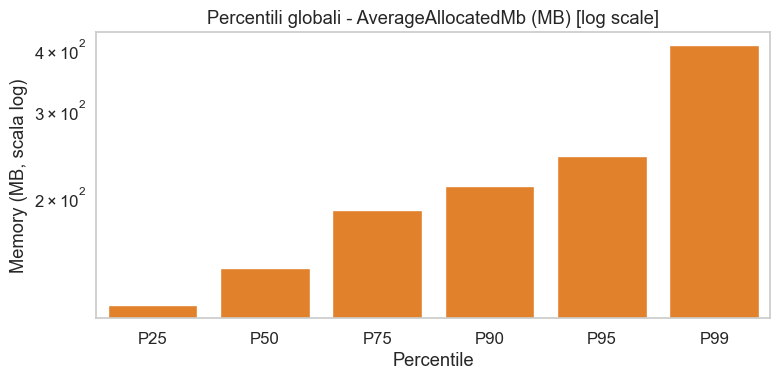


Top 10 app per mediana memoria (MB):
bd35c5fc19219ff09b493a045695512d3dced53e365a4047daf6379eaab0abad    1366.0
07a217a2813f9196d75ba1f5b1dea208f89b4113123eaa338326a3f8876fae99    1130.5
1055ce9522214dfedb4d8571b02849b3496521b9b5840fc9d1fa7d4bf472e601    1097.0
911242ef93348b8eb9c33475afac73cc18f87ce4707510a6312bcf91c161f5b9    1048.0
60393a5c156c1905114e7104d51cff90fbf6ca7068c96492a18ff1dd13e5becc     991.5
38d83139ee29a31131a033865f3ef7f1e9f35034e6271328f74204943f9eccfb     986.5
93147c26bad175e99e0911bf3bf3c4100528aba2df92ebdde7f9a7c24ad938f5     974.0
6267277a3b45fd33fd0ec553640d4c7e346468739a2c63171e844d8103fe8122     950.5
ef772dfef479f860c994db2efbf393b2ddd2cbbc4ccaf60cd614c67859b5c4dc     939.0
5d717bfcb7a9c4ce806f6fdd4c3fc80e6fef23b9e37765a107a3bb2e01f89983     933.0

Top 10 app per Pct99 memoria (MB):
b02b88a988c6f7a921f0bbb932ebe4a5c653e1887d54ce8d68a73fd32c02b2cb    1524.0
dea97cb53d119383e1d392219c3f1820e6a8e43b5879857bc68e116a323170ff    1522.0
55bb2701596bf92e70afab539a

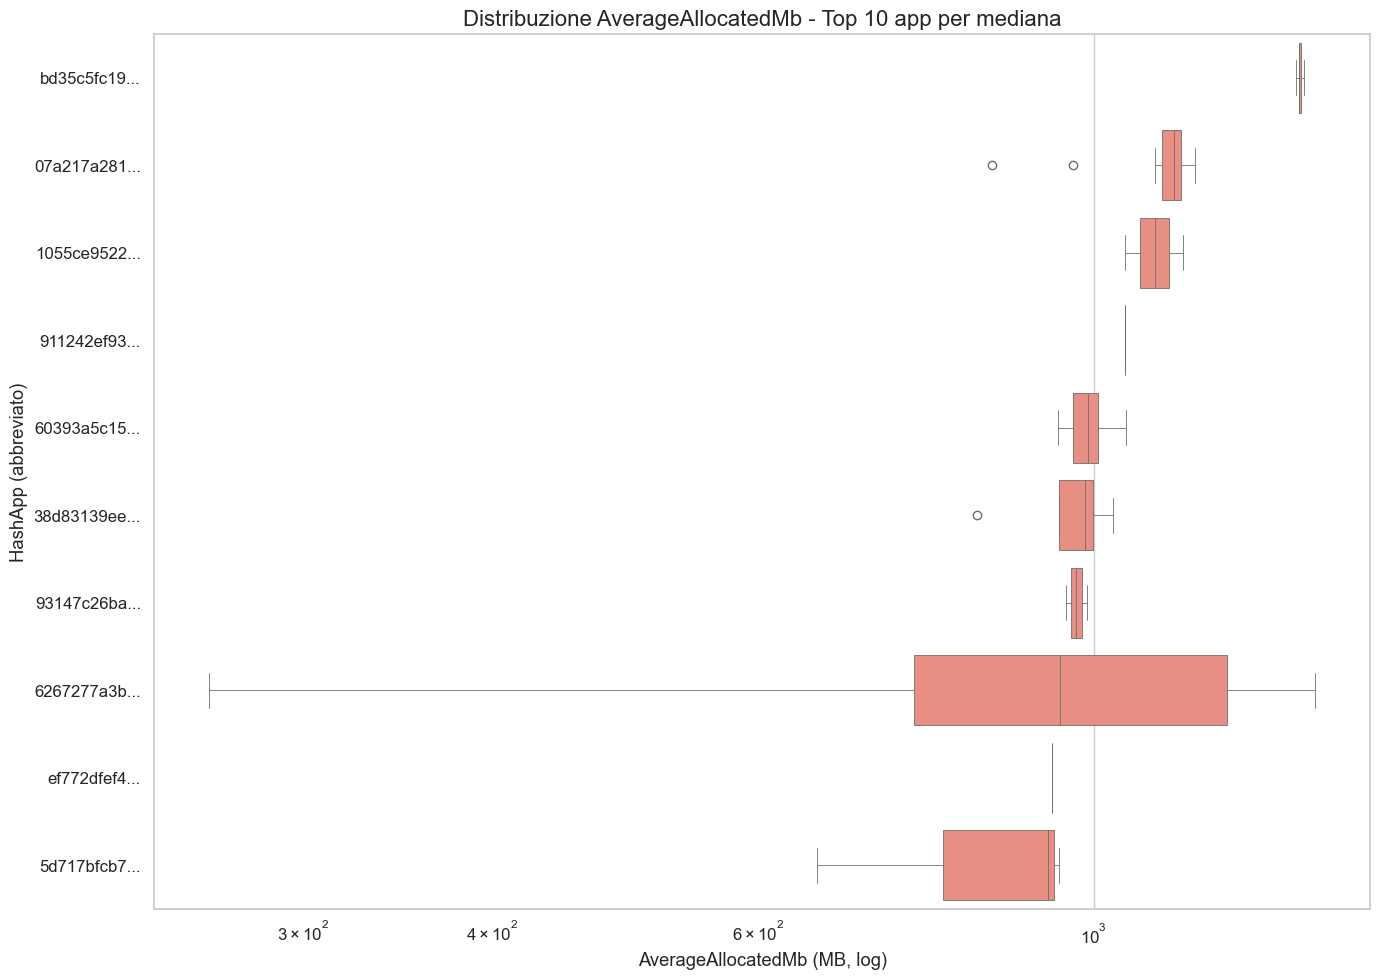

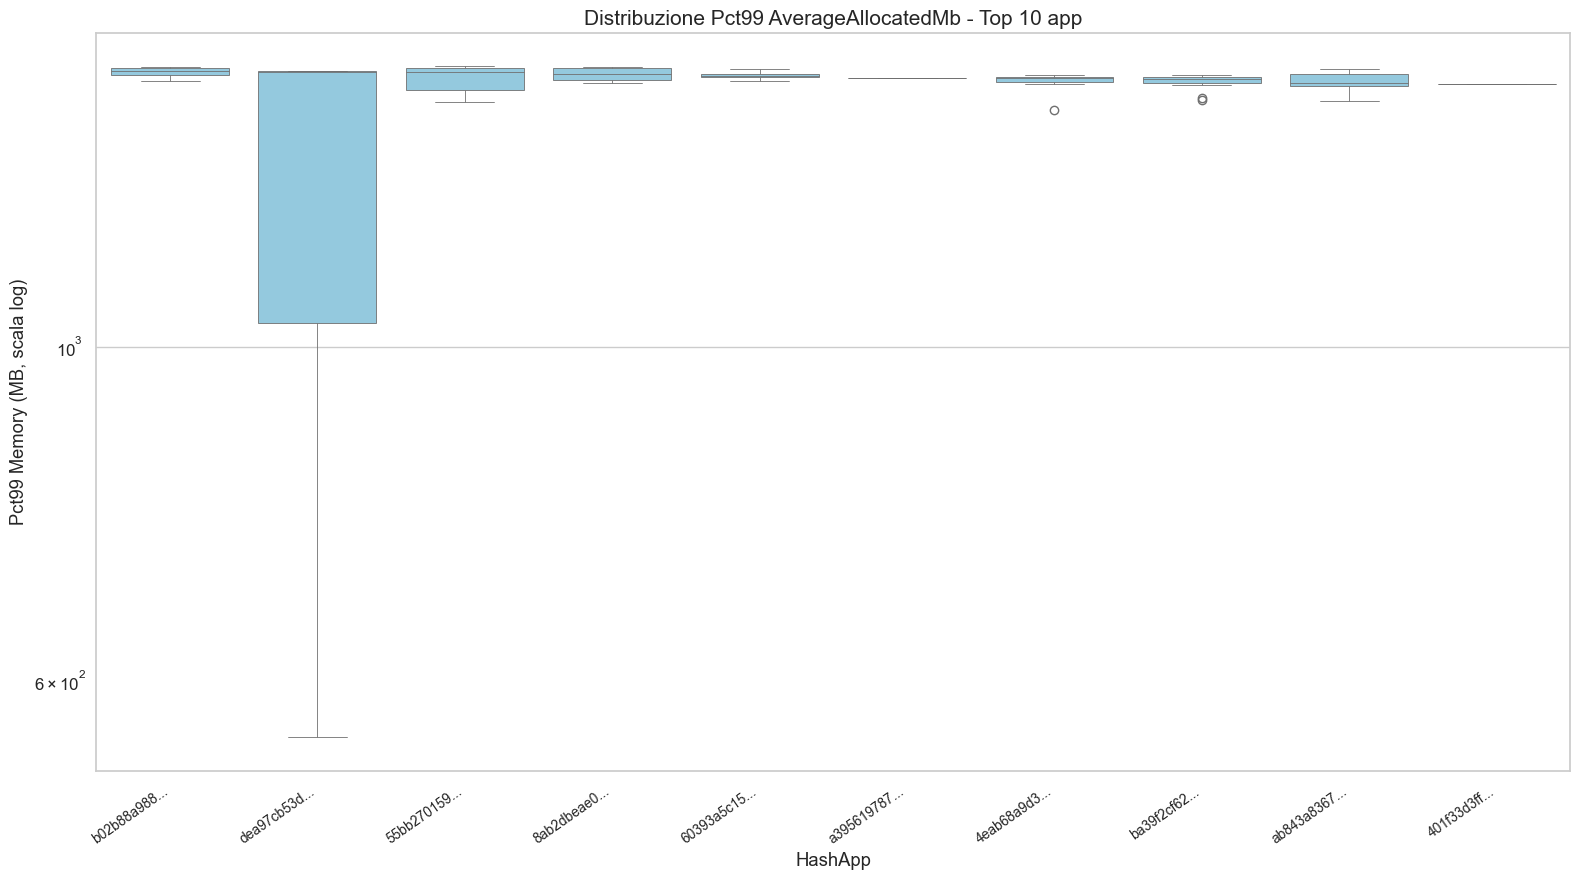

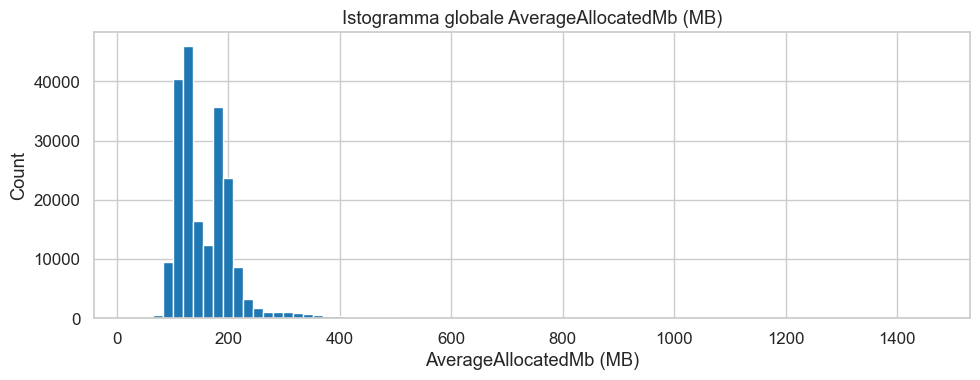

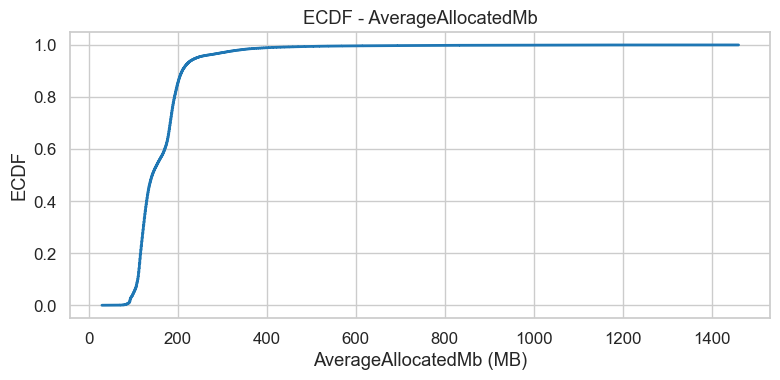


Anomalie rilevate: 165 (salvate in output/memory_anomalies.csv)
Analisi memoria completata. Figure e CSV salvati in 'figs/' e 'output/'


In [8]:
print("Analisi memoria allocata in streaming per RAM limitata...")

key_cols = ["HashOwner", "HashApp"]
mem_cols = [
    "SampleCount", "AverageAllocatedMb",
    "AverageAllocatedMb_pct5", "AverageAllocatedMb_pct25",
    "AverageAllocatedMb_pct50", "AverageAllocatedMb_pct75",
    "AverageAllocatedMb_pct95", "AverageAllocatedMb_pct99",
    "AverageAllocatedMb_pct100"
]
all_cols = key_cols + mem_cols

# Il dataset della memoria contiene diverse statistiche percentili pre-calcolate.
# Si aggregano i valori per app, in particolar modo su:
#   - mediana,
#   - pct95,
#   - pct99.
# Questo aiuta a identificare applicazioni con comportamenti anomali.

app_memory = defaultdict(list)
app_pct95 = defaultdict(list)
app_pct99 = defaultdict(list)
app_samplec = defaultdict(list)
global_memory = []

# Streaming dei batch
for batch in ds_memory.to_batches(columns=all_cols):
    df = batch.to_pandas()
    if "AverageAllocatedMb" not in df.columns:
        continue
    df = df[df["AverageAllocatedMb"].notna() & (df["AverageAllocatedMb"] >= 0)]

    global_memory.extend(df["AverageAllocatedMb"].tolist())

    for app, grp in df.groupby("HashApp"):
        vals = grp["AverageAllocatedMb"].dropna().tolist()
        if vals: app_memory[app].extend(vals)
        if "AverageAllocatedMb_pct95" in grp.columns: app_pct95[app].extend(grp["AverageAllocatedMb_pct95"].dropna().tolist())
        if "AverageAllocatedMb_pct99" in grp.columns: app_pct99[app].extend(grp["AverageAllocatedMb_pct99"].dropna().tolist())
        if "SampleCount" in grp.columns: app_samplec[app].extend(grp["SampleCount"].dropna().tolist())

# Statistiche globali memoria
global_series = pd.Series(global_memory)
mem_stats = {
    "Median": global_series.median(),
    "P90": global_series.quantile(0.90),
    "P95": global_series.quantile(0.95),
    "P99": global_series.quantile(0.99),
    "Mean": global_series.mean(),
    "Min": global_series.min(),
    "Max": global_series.max(),
}
print("Statistiche globali della memoria allocata (MB):")
for k, v in mem_stats.items():
    print(f"- {k}: {v:.2f}")

# Salvataggio e grafico percentili globali
percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = global_series.quantile([p/100 for p in percentiles])
pd.DataFrame({
    "Percentile": [f"P{p}" for p in percentiles],
    "Value_Mb": percentile_values.values
}).to_csv(os.path.join(OUTPUT_DIR, "memory_global_percentiles.csv"),
         index=False, sep=';', encoding='utf-8')

plt.figure(figsize=(8,4))
sns.barplot(x=[f"P{p}" for p in percentiles], y=percentile_values.values, color="tab:orange")
plt.yscale("log")
plt.title("Percentili globali - AverageAllocatedMb (MB) [log scale]")
plt.ylabel("Memory (MB, scala log)")
plt.xlabel("Percentile")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "memory_global_percentiles_log.png"))
plt.show()

# Top 10 app per mediana e pct99
app_median_mem = {a: pd.Series(v).median() for a,v in app_memory.items() if len(v)>0}
top10_apps_by_median = pd.Series(app_median_mem).sort_values(ascending=False).head(10)

app_pct99_median = {a: (pd.Series(v).median() if len(v)>0 else np.nan) for a,v in app_pct99.items()}
top10_apps_by_pct99 = pd.Series(app_pct99_median).sort_values(ascending=False).head(10)

pd.DataFrame({"App": top10_apps_by_median.index, "MedianMemory_MB": top10_apps_by_median.values})\
  .to_csv(os.path.join(OUTPUT_DIR, "top10_apps_by_median_memory.csv"), index=False, sep=';', encoding='utf-8')
pd.DataFrame({"App": top10_apps_by_pct99.index, "Pct99Memory_MB": top10_apps_by_pct99.values})\
  .to_csv(os.path.join(OUTPUT_DIR, "top10_apps_by_pct99_memory.csv"), index=False, sep=';', encoding='utf-8')

print("\nTop 10 app per mediana memoria (MB):")
print(top10_apps_by_median.to_string())
print("\nTop 10 app per Pct99 memoria (MB):")
print(top10_apps_by_pct99.to_string())


# Top10
def build_repeated_df(series_index, source_dict, col_name):
    rows = []
    for k in series_index:
        vals = source_dict.get(k, [])
        rows.extend([(k, x) for x in vals])
    return pd.DataFrame(rows, columns=[col_name+"_App", col_name])

top10_median_df = build_repeated_df(top10_apps_by_median.index, app_memory, "Memory")
top10_median_df["ShortID"] = top10_median_df["Memory_App"].str[:10] + "..."

plt.figure(figsize=(14,10))

sns.boxplot(
    y="ShortID",
    x="Memory",
    data=top10_median_df,
    color="salmon",
    linewidth=0.6
)

plt.xscale("log")
plt.title("Distribuzione AverageAllocatedMb - Top 10 app per mediana", fontsize=16)
plt.xlabel("AverageAllocatedMb (MB, log)")
plt.ylabel("HashApp (abbreviato)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "top10_apps_median_memory_boxplot_log.png"))
plt.show()

top10_pct99_df = build_repeated_df(top10_apps_by_pct99.index, app_pct99, "Pct99")
# Abbreviazione hash
top10_pct99_df["ShortID"] = top10_pct99_df["Pct99_App"].str[:10] + "..."

plt.figure(figsize=(16,9))
sns.boxplot(
    x="ShortID", y="Pct99",
    data=top10_pct99_df,
    color="skyblue",
    linewidth=0.6
)

plt.yscale("log")
plt.title("Distribuzione Pct99 AverageAllocatedMb - Top 10 app", fontsize=15)
plt.ylabel("Pct99 Memory (MB, scala log)")
plt.xlabel("HashApp")

plt.xticks(rotation=35, ha="right", fontsize=10)
plt.tight_layout()

plt.savefig(os.path.join(FIGS_DIR, "top10_apps_pct99_boxplot_log.png"))
plt.show()


# Distribuzione globale: istogramma + ECDF
plt.figure(figsize=(10,4))
plt.hist(global_series, bins=80)
plt.title("Istogramma globale AverageAllocatedMb (MB)")
plt.xlabel("AverageAllocatedMb (MB)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "memory_global_hist.png"))
plt.show()

sorted_vals = np.sort(global_series.dropna())
ecdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
plt.figure(figsize=(8,4))
plt.plot(sorted_vals, ecdf)
plt.title("ECDF - AverageAllocatedMb")
plt.xlabel("AverageAllocatedMb (MB)")
plt.ylabel("ECDF")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "memory_global_ecdf.png"))
plt.show()

# Identificazione outlier rilevanti confrontando pct95 e pct99 e analizzando
# la quantità di campioni disponibili. Vengono segnalate come anomalie: 
# applicazioni con spike di memoria, con pochi campioni o con mediane insolitamente elevate.

anomalies = []
for app in set(list(app_memory.keys()) + list(app_pct95.keys()) + list(app_pct99.keys())):
    median_mem = pd.Series(app_memory[app]).median() if len(app_memory.get(app, []))>0 else np.nan
    pct95_med = pd.Series(app_pct95[app]).median() if len(app_pct95.get(app, []))>0 else np.nan
    pct99_med = pd.Series(app_pct99[app]).median() if len(app_pct99.get(app, []))>0 else np.nan
    samplecount_mean = pd.Series(app_samplec[app]).mean() if len(app_samplec.get(app, []))>0 else np.nan

    spike_flag = pct99_med > 2*pct95_med if not np.isnan(pct99_med) and not np.isnan(pct95_med) else False
    low_samples_flag = samplecount_mean < 10 if not np.isnan(samplecount_mean) else False
    always_high_flag = median_mem > 500 if not np.isnan(median_mem) else False

    if spike_flag or low_samples_flag or always_high_flag:
        anomalies.append({
            "App": app,
            "MedianMemory_MB": median_mem,
            "Pct95_Median_MB": pct95_med,
            "Pct99_Median_MB": pct99_med,
            "MeanSampleCount": samplecount_mean,
            "SpikeFlag": spike_flag,
            "LowSamplesFlag": low_samples_flag,
            "AlwaysHighFlag": always_high_flag
        })

anomalies_df = pd.DataFrame(anomalies).sort_values(
    ["SpikeFlag","AlwaysHighFlag","MedianMemory_MB"],
    ascending=[False, False, False]
)
anomalies_df.to_csv(os.path.join(OUTPUT_DIR, "memory_anomalies.csv"), index=False, sep=';', encoding='utf-8')
print(f"\nAnomalie rilevate: {len(anomalies_df)} (salvate in output/memory_anomalies.csv)")

print("Analisi memoria completata. Figure e CSV salvati in 'figs/' e 'output/'")

## 7) Analisi Concatenazione

Analisi ottimizzata della concatenazione delle funzioni...


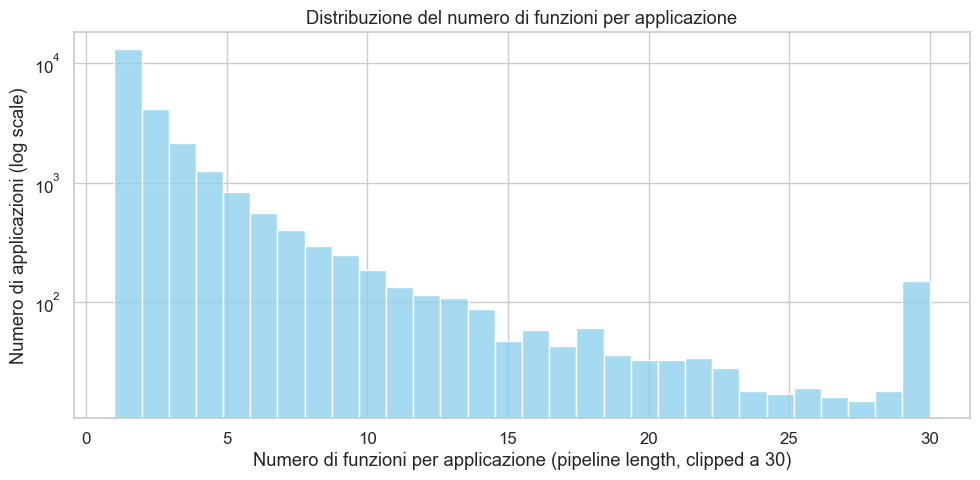


Statistiche sul numero di funzioni per applicazione:
count    24274.000000
mean         2.980926
std          5.654254
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        302.000000
Name: HashFunction, dtype: float64

Applicazioni con possibili pipeline: 6,411


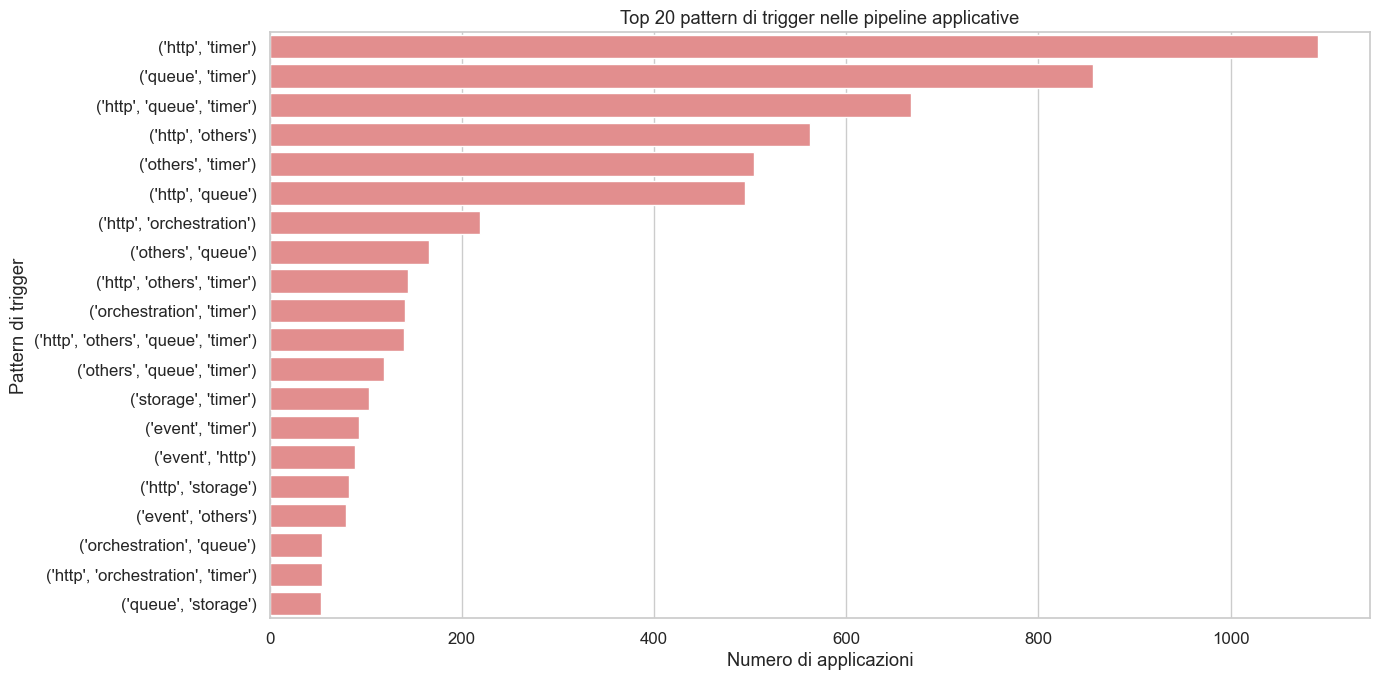

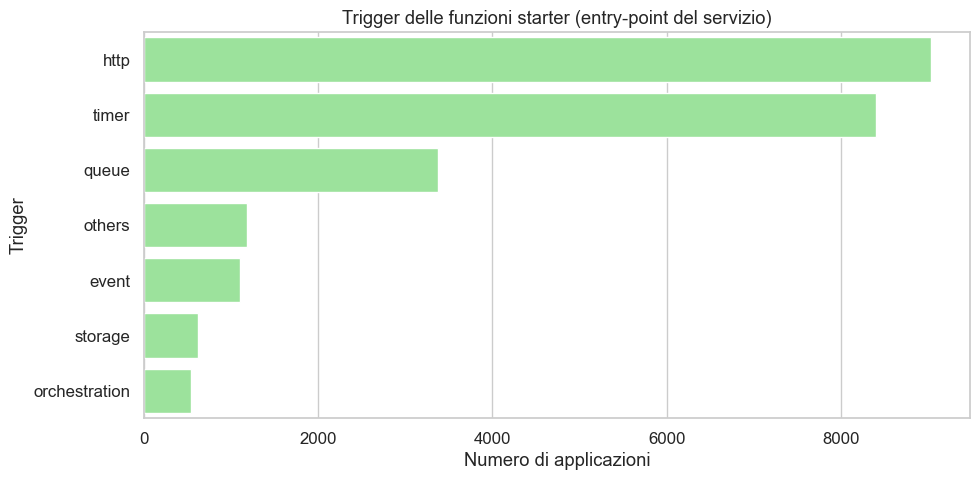


Riepilogo concatenazione delle funzioni:
- Numero_app_totali: 24274
- App_con_pipeline: 6411
- Percentuale_pipeline: 26.41
- Funzioni_medie_pipeline: 2.9809260937628737
- Funzioni_max_pipeline: 302
- Pattern_trigger_top3: {('http', 'timer'): 1091, ('queue', 'timer'): 857, ('http', 'queue', 'timer'): 668}

Analisi concatenazione completa. Figure e CSV salvati in 'figs/' e 'output/'


In [9]:
# Il dataset non contiene request-ID, non si può ricostruire la catena
# operativa reale delle chiamate. 

# Analisi della concatenazione strutturale delle funzioni:
# - quante funzioni compongono un'applicazione,
# - quali tipologie di trigger coesistono nella stessa applicazione,
# - quale funzione è il probabile entry-point,
# - pattern strutturali ricorrenti tra i trigger.

print("Analisi ottimizzata della concatenazione delle funzioni...")

inv_simple = ds_invocations.to_table(
    columns=["HashApp", "HashFunction", "Trigger"]
).to_pandas().drop_duplicates() 

# Numero di funzioni per applicazione

func_per_app = inv_simple.groupby("HashApp")["HashFunction"].nunique()

plt.figure(figsize=(10,5))
sns.histplot(
    func_per_app.clip(upper=30),  
    bins=30,
    color="skyblue"
)
plt.yscale("log")
plt.title("Distribuzione del numero di funzioni per applicazione")
plt.xlabel("Numero di funzioni per applicazione (pipeline length, clipped a 30)")
plt.ylabel("Numero di applicazioni (log scale)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "concat_num_functions_per_app.png"))
plt.show()

print("\nStatistiche sul numero di funzioni per applicazione:")
print(func_per_app.describe())

# Pattern dei trigger
triggers_per_app = inv_simple.groupby("HashApp")["Trigger"].unique()

# Se un App ha più di un trigger, allora si avrà una potenziale catena di funzioni
pipeline_apps = {
    app: trigs for app, trigs in triggers_per_app.items()
    if len(trigs) > 1
}

print(f"\nApplicazioni con possibili pipeline: {len(pipeline_apps):,}")

# Top 20 pattern trigger
trigger_set_counts = (
    pd.Series([tuple(sorted(v)) for v in pipeline_apps.values()])
    .value_counts()
    .head(20)
)

plt.figure(figsize=(14,7))
sns.barplot(
    y=trigger_set_counts.index.astype(str),
    x=trigger_set_counts.values,
    color="lightcoral"
)
plt.title("Top 20 pattern di trigger nelle pipeline applicative")
plt.xlabel("Numero di applicazioni")
plt.ylabel("Pattern di trigger")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "concat_trigger_sets.png"))
plt.show()


# Identificazione delle funzioni starter (entry-point), usando:
# - func_counter (calcolato nella sezione 4) per il totale delle invocazioni per funzione
# - una mappatura HashFunction

func_struct_df = inv_simple.copy()  # già contiene HashApp, HashFunction, Trigger

func_to_app = {
    row.HashFunction: (row.HashApp, row.Trigger)
    for row in func_struct_df.itertuples()
}

# Per ogni HashApp viene creata una lista di: HashFunction, totale_invocazioni, Trigger
app_fcalls = {}

for func, total_inv in func_counter.items():  # func_counter = già calcolato in sezione 4
    if func not in func_to_app:
        continue
    app, trig = func_to_app[func]
    app_fcalls.setdefault(app, []).append((func, total_inv, trig))

# Funzione starter = funzione più invocata per app
starter_rows = []
for app, flist in app_fcalls.items():
    func, totinv, trig = max(flist, key=lambda x: x[1]) 
    starter_rows.append({
        "HashApp": app,
        "HashFunction": func,
        "Trigger": trig,
        "TotalInvocations": totinv
    })

starter_df = pd.DataFrame(starter_rows)

plt.figure(figsize=(10,5))
sns.countplot(
    y=starter_df["Trigger"],
    order=starter_df["Trigger"].value_counts().index,
    color="lightgreen"
)
plt.title("Trigger delle funzioni starter (entry-point del servizio)")
plt.xlabel("Numero di applicazioni")
plt.ylabel("Trigger")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "concat_starter_triggers.png"))
plt.show()

# Riepilogo

summary = {
    "Numero_app_totali": len(func_per_app),
    "App_con_pipeline": len(pipeline_apps),
    "Percentuale_pipeline": round(len(pipeline_apps)/len(func_per_app)*100, 2),
    "Funzioni_medie_pipeline": func_per_app.mean(),
    "Funzioni_max_pipeline": func_per_app.max(),
    "Pattern_trigger_top3": trigger_set_counts.head(3).to_dict()
}

print("\nRiepilogo concatenazione delle funzioni:")
for k,v in summary.items():
    print(f"- {k}: {v}")

pd.DataFrame(list(summary.items()), columns=["Metric","Value"]) \
  .to_csv(os.path.join(OUTPUT_DIR, "concat_summary.csv"),
          sep=';', index=False)

print("\nAnalisi concatenazione completa. Figure e CSV salvati in 'figs/' e 'output/'")

## 8) Analisi incrociata Invocations–Durations–Memory


Analisi Incrociata (invocations ⨝ durations ⨝ memory)

Caricamento chiavi invocations...
   → funzioni in invocations: 72,359

Caricamento chiavi durations...
   → funzioni in durations: 82,375

Caricamento chiavi memoria...
   → app in memory: 23,961

 Coverage tra dataset (uniche funzioni/app accoppiabili)
 - Invocations ∩ Durations: 71,597
 - Invocations ∩ Durations ∩ Memory: 69,729
   → campione creato: 45,008 righe

STATISTICHE INCROCIATE
        Invocations  AvgDuration_ms  CountDurSamples     AvgMem_MB
count  4.500800e+04    45008.000000     4.500800e+04  45008.000000
mean   2.006673e+04    10753.671969     2.085559e+04    169.870556
std    8.204179e+05    42742.145478     1.140679e+06     73.898480
min    1.000000e+00        0.000000     1.000000e+00     48.000000
50%    3.100000e+01      745.000000     2.400000e+01    158.000000
90%    1.561300e+03    19023.100000     1.440000e+03    224.000000
99%    1.343079e+05   244210.370000     1.176917e+05    460.000000
max    1.274717

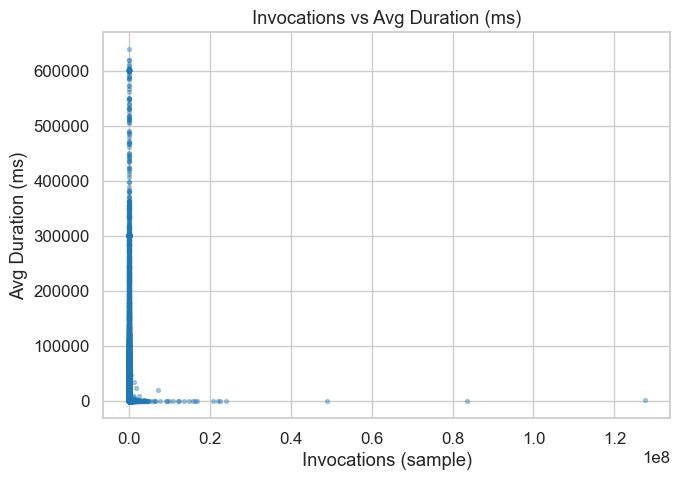

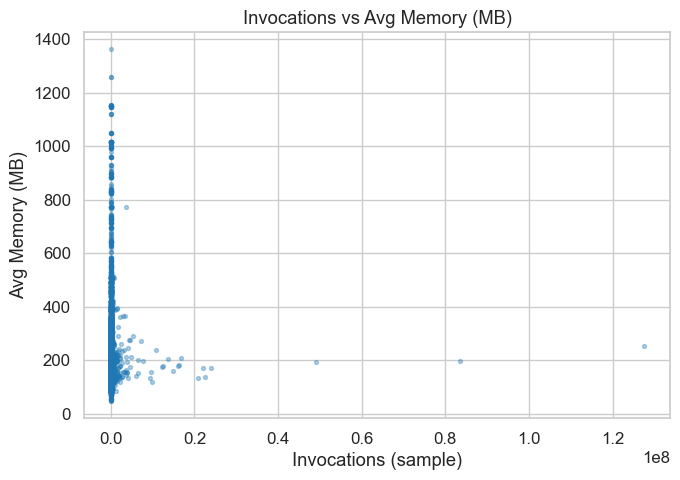

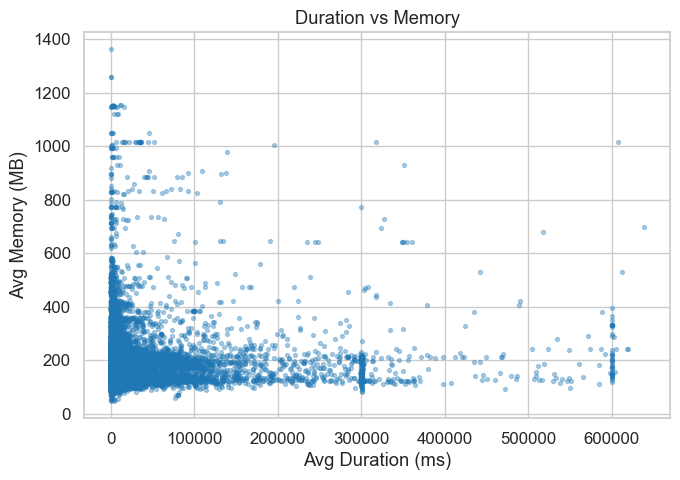

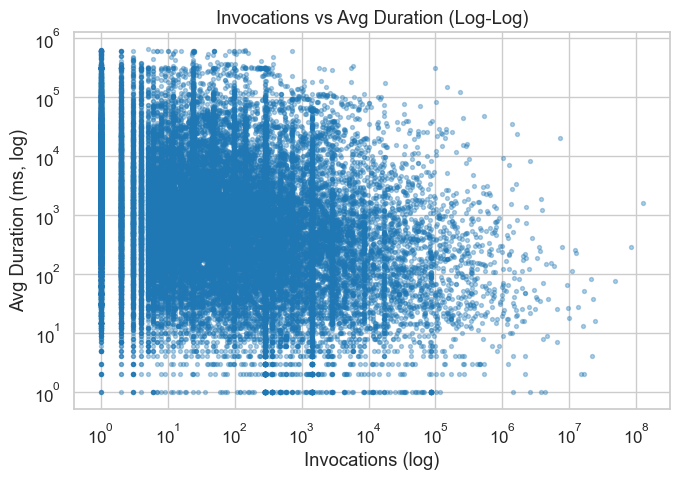

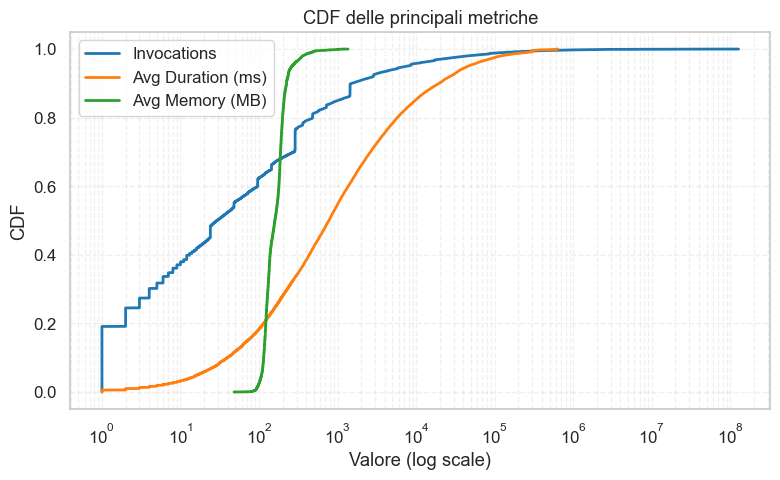

Analisi incrociata completata. Figure e CSV salvati in 'figs/' e 'output/'


In [10]:
print("\nAnalisi Incrociata (invocations ⨝ durations ⨝ memory)")
# I tre dataset non possono essere uniti direttamente a causa delle elevate dimensioni complessive.
# Per questo motivo viene costruito manualmente un campione incrociato nel seguente modo:
#   1. estrazione delle chiavi comuni tra invocations, durations e memory;
#   2. costruizione di due dizionari parziali (durations e memoria) in streaming;
#   3. si scorre le invocations in streaming e genero un campione di righe coerenti.

# Ogni record del campione contiene:
#   - numero totale di invocazioni,
#   - durata media della funzione,
#   - memoria media allocata dall’app,
#   - numero di campioni di durata raccolti.

# Questo campione permette di esplorare correlazioni e pattern tra
# intensità di utilizzo, prestazioni e footprint di memoria.
# L’obiettivo non è ricostruire l’intero join tra dataset (troppo pesante),
# ma ottenere un sottoinsieme statisticamente rappresentativo del workload.

inv_keys = set()    
dur_keys = set()
mem_keys = set()

print("\nCaricamento chiavi invocations...")
for batch in ds_invocations.to_batches(columns=["HashOwner","HashApp","HashFunction"]):
    df = batch.to_pandas()
    inv_keys.update(zip(df.HashOwner, df.HashApp, df.HashFunction))
print(f"   → funzioni in invocations: {len(inv_keys):,}")

print("\nCaricamento chiavi durations...")
for batch in ds_durations.to_batches(columns=["HashOwner","HashApp","HashFunction"]):
    df = batch.to_pandas()
    dur_keys.update(zip(df.HashOwner, df.HashApp, df.HashFunction))
print(f"   → funzioni in durations: {len(dur_keys):,}")

print("\nCaricamento chiavi memoria...")
for batch in ds_memory.to_batches(columns=["HashOwner","HashApp"]):
    df = batch.to_pandas()
    mem_keys.update(zip(df.HashOwner, df.HashApp))
print(f"   → app in memory: {len(mem_keys):,}")


# Coverage e intersezioni

common_inv_dur = inv_keys & dur_keys
common_all = {(o,a,f) for (o,a,f) in common_inv_dur if (o,a) in mem_keys}

print("\n Coverage tra dataset (uniche funzioni/app accoppiabili)")
print(f" - Invocations ∩ Durations: {len(common_inv_dur):,}")
print(f" - Invocations ∩ Durations ∩ Memory: {len(common_all):,}")


# Costruzione campione incrociato

target_size = 30_000
sample = []

# Dizionari 
dur_dict = {}
for batch in ds_durations.to_batches(columns=["HashOwner","HashApp","HashFunction","Average","Count"]):
    df = batch.to_pandas()
    for r in df.itertuples(index=False):
        dur_dict[(r.HashOwner, r.HashApp, r.HashFunction)] = (r.Average, r.Count)
    if len(dur_dict) > 100_000:
        break

mem_dict = {}
for batch in ds_memory.to_batches(columns=["HashOwner","HashApp","AverageAllocatedMb"]):
    df = batch.to_pandas()
    for r in df.itertuples(index=False):
        mem_dict[(r.HashOwner, r.HashApp)] = r.AverageAllocatedMb
    if len(mem_dict) > 50_000:
        break

# Sampling invocations
for batch in ds_invocations.to_batches():
    df = batch.to_pandas()
    minute_cols = [c for c in df.columns if c.isdigit()]
    df["TotalInvocations"] = df[minute_cols].sum(axis=1)

    for r in df.itertuples(index=False):
        key = (r.HashOwner, r.HashApp, r.HashFunction)
        if key not in dur_dict: continue
        if (r.HashOwner, r.HashApp) not in mem_dict: continue
        sample.append((
            r.TotalInvocations,
            dur_dict[key][0],
            dur_dict[key][1],
            mem_dict[(r.HashOwner, r.HashApp)]
        ))
    if len(sample) >= target_size:
        break

sample_df = pd.DataFrame(sample, columns=[
    "Invocations",
    "AvgDuration_ms",
    "CountDurSamples",
    "AvgMem_MB"
])
print(f"   → campione creato: {len(sample_df):,} righe")


# Statistiche incrociate

print("\nSTATISTICHE INCROCIATE")
print(sample_df.describe(percentiles=[0.5,0.9,0.99]))

# Scatter lineari
plt.figure(figsize=(7,5))
plt.scatter(sample_df["Invocations"], sample_df["AvgDuration_ms"], s=8, alpha=0.35)
plt.title("Invocations vs Avg Duration (ms)")
plt.xlabel("Invocations (sample)")
plt.ylabel("Avg Duration (ms)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "inv_vs_duration.png"))
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(sample_df["Invocations"], sample_df["AvgMem_MB"], s=8, alpha=0.35)
plt.title("Invocations vs Avg Memory (MB)")
plt.xlabel("Invocations (sample)")
plt.ylabel("Avg Memory (MB)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "inv_vs_memory.png"))
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(sample_df["AvgDuration_ms"], sample_df["AvgMem_MB"], s=8, alpha=0.35)
plt.title("Duration vs Memory")
plt.xlabel("Avg Duration (ms)")
plt.ylabel("Avg Memory (MB)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "duration_vs_memory.png"))
plt.show()

# Scatter log-log
sample_df_filtered = sample_df[(sample_df > 0).all(axis=1)]
plt.figure(figsize=(7,5))
plt.scatter(sample_df_filtered["Invocations"], sample_df_filtered["AvgDuration_ms"], s=8, alpha=0.35)
plt.xscale("log")
plt.yscale("log")
plt.title("Invocations vs Avg Duration (Log-Log)")
plt.xlabel("Invocations (log)")
plt.ylabel("Avg Duration (ms, log)")
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "inv_vs_duration_loglog.png"))
plt.show()

# CDF metriche principali

plt.figure(figsize=(8,5))
for col, label in [("Invocations", "Invocations"),
                   ("AvgDuration_ms", "Avg Duration (ms)"),
                   ("AvgMem_MB", "Avg Memory (MB)")]:
    vals = sample_df_filtered[col].sort_values()
    y = np.linspace(0, 1, len(vals))
    plt.plot(vals, y, label=label)
plt.xscale("log")
plt.xlabel("Valore (log scale)")
plt.ylabel("CDF")
plt.title("CDF delle principali metriche")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS_DIR, "cdf_metrics.png"))
plt.show()

print("Analisi incrociata completata. Figure e CSV salvati in 'figs/' e 'output/'")

## 9) Recap finale

In [11]:
print("RECAP DEI PRINCIPALI RISULTATI")

recap_dict = {
    "Owner totali": n_owners,
    "App totali": n_apps,
    "Funzioni totali": n_funcs,
    "Funzioni con durations": n_fun_dur,
    "Funzioni senza durations": n_fun_no_dur,
    "App con memory": n_app_mem,
    "App senza memory": n_app_no_mem,
    "Minuto di picco invocazioni": f"{peak_minute//60}:{peak_minute%60}",
    "Minuto minimo invocazioni": f"{min_minute//60}:{min_minute%60}",
    "Top 3 funzioni più invocate": top10_funcs['Function'].head(3).tolist(),
    "Top 3 app più invocate": top10_apps['App'].head(3).tolist(),
    "Top 3 funzioni più lente (mediana ms)": top_slowest_funcs.head(3).to_dict(),
    "Top 3 app più lente (mediana ms)": top_slowest_apps.head(3).to_dict(),
    "Top 10 app per memoria mediana (MB)": top10_apps_by_median.to_dict(),
    "Anomalie memoria rilevate": len(anomalies_df)
}

for k, v in recap_dict.items():
    print(f"- {k}: {v}")

# Salvataggio CSV recap
pd.DataFrame(list(recap_dict.items()), columns=["Metric", "Value"])\
  .to_csv(os.path.join(OUTPUT_DIR, "recap_summary.csv"), index=False, sep=';', encoding='utf-8')

print("Recap salvato in output/recap_summary.csv")


RECAP DEI PRINCIPALI RISULTATI
- Owner totali: 14681
- App totali: 24274
- Funzioni totali: 72359
- Funzioni con durations: 71597
- Funzioni senza durations: 762
- App con memory: 23431
- App senza memory: 843
- Minuto di picco invocazioni: 14:8
- Minuto minimo invocazioni: 4:27
- Top 3 funzioni più invocate: ['8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e', '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc', 'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c']
- Top 3 app più invocate: ['94409f2485ebd997a61cbd06906595e4f3ef1846ed7406f9e3fa03cfa4d5060a', '734bb9a04a1d2e6917f75e46c093a6c95d114970e624b9975b98bad86c12f14b', '4b75f2532af503341fd11268d543ad0119dd2e8950a022f2851b4a5d0c8a5e0a']
- Top 3 funzioni più lente (mediana ms): {'0ab944f5c72a4b9f807931d23f704cfaf8296477f3c4a64fe77807280fcd5c6c': 886277.0, '1e5bfcc662ff982b62ca347d1058f43780275234da00b4b5162e6a887d82a56a': 650456.0, 'd3209b753752c8641cde05ba81b3ceb0d175b1f986fee7872a9368